# Bellingham Property Price Prediction (Supervised Learning)

**Author:** Michael Walker
**Date:** October 6, 2025
**Video (YouTube):** https://youtu.be/f08v8g7KcBM
**Notebook (GitHub):** https://github.com/MSVWalker/cu-boulder-ms-ai/blob/39220bbca46c148526563a6d7f418700240718fe/Introduction-to-Machine-Learning/supervised/Supervised_Learning_Project.ipynb

---

# Bellingham Property Price Prediction: A Supervised Learning Analysis

## Table of Contents

### [1. Problem Description & Business Context](#1-problem-description-business-context)
- [1.1 Business Problem](#11-business-problem)
- [1.2 Dataset Overview](#12-dataset-overview)

### [2. Data Cleaning & Preprocessing](#2-data-cleaning-preprocessing)

### [3. Exploratory Data Analysis (EDA)](#3-exploratory-data-analysis-eda)
- [3.1 Target Variable Analysis](#31-target-variable-analysis)
- [3.2 Feature Exploration & Relationships](#32-feature-exploration-relationships)
- [3.3 Correlation Analysis](#33-correlation-analysis)

### [4. Feature Engineering](#4-feature-engineering)
- [4.1 Feature Creation & Transformations](#41-feature-creation-transformations)

### [5. Modeling Approach](#5-modeling-approach)
- [5.1 Baseline Models (Raw Features)](#51-baseline-models-raw-features)
- [5.2 Models with Feature Engineering](#52-models-with-feature-engineering)
- [5.3 Regularized Linear Models](#53-regularized-linear-models)
- [5.4 Random Forest](#54-random-forest)
- [5.5 Tuned XGBoost (Final Model)](#55-tuned-xgboost-final-model)

### [6. Results & Analysis](#6-results-analysis)
- [6.1 Model Comparison Table](#61-model-comparison-table)
- [6.2 Feature Importances & Diagnostics](#62-feature-importances-diagnostics)

### [7. Discussion & Conclusions](#7-discussion-conclusions)
- [7.1 Key Learnings](#71-key-learnings)
- [7.2 Limitations](#72-limitations)
- [7.3 Recommendations & Future Work](#73-recommendations-future-work)

---


# 1. Problem Description & Business Context

## 1.1 Business Problem

This project addresses a **real estate price prediction problem** using supervised machine learning. The primary goal is to build predictive models that accurately estimate residential property values in **Bellingham, Washington**, leveraging both property characteristics and broader market indicators.

**Key Business Questions:**
- Which property features are most predictive of market value?
- How accurately can we estimate property prices using machine learning models?
- What insights can help real estate professionals and investors make informed purchase, sale, and investment decisions?

## 1.2 Dataset Overview

**Source:** Property records were obtained from **PropStream**, a commercial real estate data platform that aggregates assessor, MLS, and public record data. The dataset was exported via my PropStream account.

**Data Citation:**
PropStream. (2025). *Bellingham, WA residential property dataset*. Retrieved from https://www.propstream.com

**Dataset Summary:**
- **Rows:** 7,001 properties
- **Original Features:** 51 columns
- **Target Variable:** MLS Amount (market listing price)
- **Problem Type:** Supervised learning – regression (continuous price prediction)

**Key Feature Categories:**
- **Property Characteristics:** Bedrooms, bathrooms, building square footage, lot size, year built
- **Market Data:** Last sale amount, assessed value, MLS listing amount
- **Location Data:** Address, zip code, latitude/longitude
- **Property Conditions:** Quality and condition assessments
- **Owner Information:** Occupancy status, ownership type

## 1.3 Success Metrics

**Primary Evaluation Metrics:**
- **Root Mean Square Error (RMSE):** Accuracy in dollar terms
- **R-squared (R²):** Variance explained by the model
- **Mean Absolute Error (MAE):** Average absolute prediction error

**Business Success Criteria:**
- RMSE < 15% of median property value
- R² > 0.80 for strong predictive power
- Feature interpretability to provide actionable insights for real estate agents and investors

## 1.4 Motivation

Accurate price prediction models can provide a **comparative market analysis (CMA)-style tool** for real estate professionals and investors. This helps in setting fair listing prices, identifying undervalued opportunities, and supporting data-driven investment strategies in the Bellingham housing market.

## Imports & Global Configuration

This cell collects all of the project’s imports and global settings in one place for clarity and reproducibility:

- **Core libraries**: standard utilities (`warnings`, `random`, `pathlib`).
- **Numerics & data**: `numpy`, `pandas`, and `scipy` for scientific utilities.
- **Visualization**: `matplotlib` and `seaborn` with global style defaults set.
- **Scikit-learn (ML toolkit)**: preprocessing, linear models, tree ensembles, cross-validation, feature selection, and evaluation metrics.
- **Spatial/Neighbors**: `BallTree` for efficient nearest-neighbor queries if needed.
- **Gradient boosting**: `xgboost` for high-performance ensemble modeling.
- **Global config**: random seed for reproducibility, warnings suppressed for readability, and consistent plotting defaults.


In [1]:
# === Imports (clean & consolidated) ===

# Standard library
import warnings
import random
from typing import Dict, List, Tuple, Optional, Callable

# Numerics / data
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import randint, uniform, loguniform

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.exceptions import ConvergenceWarning

# Gradient boosting
import xgboost as xgb

# --- Global config ---
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True
sns.set_style("whitegrid")

## 2. Data Understanding & Cleaning

**Objective.** In this section I load the data, inspect schema/quality, and apply a targeted cleaning pipeline that:
1) removes PII/administrative columns,
2) standardizes types (e.g., dates, strings, booleans),
3) handles missingness,
4) normalizes ZIP codes for modeling, and
5) verifies the impact with summaries and quick visuals.

2.1 Load data

In [2]:
path = "Bellingham_Property_Database.csv"

df = pd.read_csv(path)

print("Dataset loaded successfully!")
print("Shape:", df.shape)
print("\nColumn names:\n", df.columns.tolist())

# Quick preview
print("\nHead:")
df.head(10)

Dataset loaded successfully!
Shape: (7000, 52)

Column names:
 ['Address', 'Unit #', 'City', 'State', 'Zip', 'County', 'APN', 'Owner Occupied', 'Owner 1 First Name', 'Owner 1 Last Name', 'Owner 2 First Name', 'Owner 2 Last Name', 'Mailing Care of Name', 'Mailing Address', 'Mailing Unit #', 'Mailing City', 'Mailing State', 'Mailing Zip', 'Mailing County', 'Do Not Mail', 'Property Type', 'Bedrooms', 'Total Bathrooms', 'Building Sqft', 'Lot Size Sqft', 'Effective Year Built', 'Total Assessed Value', 'Last Sale Recording Date', 'Last Sale Amount', 'Total Open Loans', 'Est. Remaining balance of Open Loans', 'Est. Value', 'Est. Loan-to-Value', 'Est. Equity', 'Total Condition', 'Interior Condition', 'Exterior Condition', 'Bathroom Condition', 'Kitchen Condition', 'Foreclosure Factor', 'MLS Status', 'MLS Date', 'MLS Amount', 'Lien Amount', 'Marketing Lists', 'Date Added to List', 'Method of Add', 'latitude', 'longitude', 'formatted_address', 'geocode_status', 'full_address']

Head:


,Address,Unit #,City,State,Zip,County,APN,Owner Occupied,Owner 1 First Name,Owner 1 Last Name,...,MLS Amount,Lien Amount,Marketing Lists,Date Added to List,Method of Add,latitude,longitude,formatted_address,geocode_status,full_address
0,3501 Riley St,NaN,Bellingham,WA,98229.0,Whatcom,380328-378057-0000,Yes,Adam,Doody,...,410000.0,NaN,1,2025-09-16 05:34:35.199588,Manual,48.747717,-122.428503,"3501 Riley St, Bellingham, WA 98229, USA",success,"3501 Riley St, Bellingham, WA, 98229.0"
1,2634 Strawberry Shore Dr,NaN,Bellingham,WA,98229.0,Whatcom,380336-040190-0000,No,David,Peterson,...,315000.0,NaN,1,2025-09-16 05:34:35.199588,Manual,48.736174,-122.375830,"2634 Strawberry Shore Dr, Bellingham, WA 98229...",success,"2634 Strawberry Shore Dr, Bellingham, WA, 98229.0"
2,307 Sudden Valley Dr,NaN,Bellingham,WA,98229.0,Whatcom,370406-322045-0000,No,NaN,Pdrl Degroff Revocable Living Trust,...,695000.0,NaN,1,2025-09-16 05:34:35.199588,Manual,48.718283,-122.345292,"307 Sudden Valley Dr, Bellingham, WA 98229, USA",success,"307 Sudden Valley Dr, Bellingham, WA, 98229.0"
3,822 E Douglas Ave,NaN,Bellingham,WA,98229.0,Whatcom,370305-439261-0000,Yes,Felix,Demello,...,365000.0,NaN,1,2025-09-16 05:34:35.199588,Manual,48.724336,-122.448449,"822 Douglas Ave, Bellingham, WA 98229, USA",success,"822 E Douglas Ave, Bellingham, WA, 98229.0"
4,3305 Sydney Ct,NaN,Bellingham,WA,98226.0,Whatcom,380316-331093-0000,Yes,Michael,Katz,...,917472.0,NaN,1,2025-09-16 05:34:35.199588,Manual,48.777511,-122.430381,"3305 Sydney Ct, Bellingham, WA 98226, USA",success,"3305 Sydney Ct, Bellingham, WA, 98226.0"
5,2716 Humboldt St,NaN,Bellingham,WA,98225.0,Whatcom,380319-487200-0000,No,Mialee,Solomons,...,525000.0,NaN,1,2025-09-16 05:34:35.199588,Manual,48.766152,-122.467514,"2716 Humboldt St, Bellingham, WA 98225, USA",success,"2716 Humboldt St, Bellingham, WA, 98225.0"
6,1401 Welling Rd,NaN,Bellingham,WA,98226.0,Whatcom,380315-140230-0000,Yes,Scott,Niebruegge,...,438000.0,NaN,1,2025-09-16 05:34:35.199588,Manual,48.781455,-122.415358,"1401 Welling Rd, Bellingham, WA 98226, USA",success,"1401 Welling Rd, Bellingham, WA, 98226.0"
7,3206 Bennett Dr,NaN,Bellingham,WA,98225.0,Whatcom,380223-243463-0000,Yes,Donna,Revell,...,321000.0,NaN,1,2025-09-16 05:34:35.199588,Manual,48.773466,-122.519813,"3206 Bennett Dr, Bellingham, WA 98225, USA",success,"3206 Bennett Dr, Bellingham, WA, 98225.0"
8,194 Sudden Valley Dr,NaN,Bellingham,WA,98229.0,Whatcom,370406-068375-0000,Yes,Carrie,Willett,...,409900.0,NaN,1,2025-09-16 05:34:35.199588,Manual,48.726374,-122.353546,"194 Sudden Valley Dr, Bellingham, WA 98229, USA",success,"194 Sudden Valley Dr, Bellingham, WA, 98229.0"
9,3519 Northwest Ave,NaN,Bellingham,WA,98225.0,Whatcom,380213-154201-0000,No,NaN,Leuba River,...,312000.0,NaN,1,2025-09-16 05:34:35.199588,Manual,48.780770,-122.501460,"3519 Northwest Ave, Bellingham, WA 98225, USA",success,"3519 Northwest Ave, Bellingham, WA, 98225.0"


2.2 Schema overview

In [3]:
# 2.2 Schema overview & quick quality check
df.info()

# quick missingness snapshot
missing_counts = df.isna().sum().sort_values(ascending=False)
print("\nMissing values (top 15):")
display(missing_counts.head(15))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 52 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Address                               7000 non-null   object 
 1   Unit #                                10 non-null     object 
 2   City                                  7000 non-null   object 
 3   State                                 7000 non-null   object 
 4   Zip                                   6983 non-null   float64
 5   County                                7000 non-null   object 
 6   APN                                   7000 non-null   object 
 7   Owner Occupied                        7000 non-null   object 
 8   Owner 1 First Name                    6205 non-null   object 
 9   Owner 1 Last Name                     7000 non-null   object 
 10  Owner 2 First Name                    4409 non-null   object 
 11  Owner 2 Last Name

Kitchen Condition       7000
Bathroom Condition      7000
Exterior Condition      7000
Interior Condition      7000
Total Condition         7000
Mailing County          7000
Unit #                  6990
Lien Amount             6965
Mailing Unit #          6778
Foreclosure Factor      5738
Owner 2 First Name      2591
Owner 2 Last Name       2341
Mailing Care of Name     841
Owner 1 First Name       795
Effective Year Built     317
dtype: int64

### 2.3 Cleaning Plan (How & Why)

- **Drop PII / administrative / high-missing columns**: remove owner names, mailing details, loan/marketing fields, and geo helpers to prevent leakage and keep only modeling-relevant features.
- **Type normalization**:
  - `Address` → `string`
  - `Owner Occupied` → boolean (`Yes=True`, `No=False`)
  - `MLS Date` → `datetime` (`errors="coerce"` so invalids become `NaT`)
- **NA handling**: convert empty/whitespace to `NA`; strict row removal to ensure a fully complete modeling table (trade-off: some data loss).
- **ZIP normalization**: extract 5-digit codes from mixed formats and one-hot encode for modeling.
- **Column order**: move `MLS Amount` (target) to the first column for readability.

> **PII note.** PII (Personally Identifiable Information) includes any data that can identify an individual (e.g., names, mailing address, APN). I removed these fields to protect privacy and prevent the model from learning spurious or non-generalizable signals (data leakage).

2.4.1 Type conversions & target first

In [4]:
# 2.4.1 Type conversions & target first
df["Address"] = df["Address"].astype("string")
df["Owner Occupied"] = df["Owner Occupied"].map({"Yes": True, "No": False}).astype(bool)
df["MLS Date"] = pd.to_datetime(df["MLS Date"], errors="coerce")

# Put MLS Amount first
cols = df.columns.tolist()
cols.insert(0, cols.pop(cols.index("MLS Amount")))
df = df[cols]

df_cleaned = df.copy()
rows_before = len(df_cleaned)

2.4.2 Column drops (PII/admin)

In [5]:
# 2.4.2 Column drops (PII/admin)
columns_to_drop = [
    'Owner 1 First Name', 'Owner 1 Last Name', 'Owner Occupied',
    'Owner 2 First Name', 'Owner 2 Last Name', 'Property Type',
    'Mailing Care of Name', 'Mailing Address', 'Mailing Unit #',
    'Mailing City', 'Mailing State', 'Mailing Zip', 'Mailing County',
    'Do Not Mail', 'Est. Value', 'Est. Loan-to-Value', 'Est. Equity',
    'Total Condition', 'Interior Condition', 'Exterior Condition',
    'Bathroom Condition', 'Kitchen Condition', 'Foreclosure Factor',
    'Date Added to List', 'Method of Add', 'Marketing Lists',
    'Total Open Loans  Est.', 'Remaining balance of Open Loans',
    'Est. Remaining balance of Open Loans', 'Total Open Loans',
    'City', 'State', 'County', 'MLS Status', 'Total Assessed Value',
    'Last Sale Recording Date', 'Last Sale Amount', 'geocode_status',
    'Unit #', 'APN', 'Lien Amount', 'formatted_address', 'full_address'
]
drop_list = [c for c in columns_to_drop if c in df_cleaned.columns]
df_cleaned = df_cleaned.drop(columns=drop_list, errors='ignore').reset_index(drop=True)

2.4.3 Handle empties & drop NA rows

In [6]:
# 2.4.3 Handle empties & drop NA rows (strict)
df_cleaned = df_cleaned.replace(r'^\s*$', pd.NA, regex=True)
df_cleaned = df_cleaned.dropna(how='any').reset_index(drop=True)

2.4.4 Normalize ZIP & make dummies

In [7]:
# 2.4.4 Normalize ZIP & make dummies
zip5 = (
    df_cleaned["Zip"].astype(str)
    .str.extract(r"(\d{5})", expand=False)   # first 5-digit block
    .astype("string")
)

zip_dummies = pd.get_dummies(zip5, prefix="Zip", prefix_sep="_", dtype=bool)
df_cleaned = pd.concat([df_cleaned.drop(columns=["Zip"]), zip_dummies], axis=1)

2.5 QA summary

In [8]:
# 2.5 QA summary
print("Added ZIP dummies:", zip_dummies.columns.tolist())
print("Counts per ZIP:\n", zip_dummies.sum().to_string())

print(f"\nRows before: {rows_before} | Rows after: {len(df_cleaned)} | Removed: {rows_before - len(df_cleaned)}")
print(f"Dropped columns: {len(drop_list)} -> {drop_list}")

print("\nRemaining columns:")
print(df_cleaned.columns.tolist())

Added ZIP dummies: ['Zip_98225', 'Zip_98226', 'Zip_98229']
Counts per ZIP:
 Zip_98225    1983
Zip_98226    1984
Zip_98229    2675

Rows before: 7000 | Rows after: 6642 | Removed: 358
Dropped columns: 41 -> ['Owner 1 First Name', 'Owner 1 Last Name', 'Owner Occupied', 'Owner 2 First Name', 'Owner 2 Last Name', 'Property Type', 'Mailing Care of Name', 'Mailing Address', 'Mailing Unit #', 'Mailing City', 'Mailing State', 'Mailing Zip', 'Mailing County', 'Do Not Mail', 'Est. Value', 'Est. Loan-to-Value', 'Est. Equity', 'Total Condition', 'Interior Condition', 'Exterior Condition', 'Bathroom Condition', 'Kitchen Condition', 'Foreclosure Factor', 'Date Added to List', 'Method of Add', 'Marketing Lists', 'Est. Remaining balance of Open Loans', 'Total Open Loans', 'City', 'State', 'County', 'MLS Status', 'Total Assessed Value', 'Last Sale Recording Date', 'Last Sale Amount', 'geocode_status', 'Unit #', 'APN', 'Lien Amount', 'formatted_address', 'full_address']

Remaining columns:
['MLS Amount'

### 2.6 Cleaning Findings & Trade-offs

- **Rows**: 7,000 → 6,642 (**–358**), reflecting strict `dropna(how="any")`.
- **Columns dropped**: 41 (PII/admin/low-value) to reduce leakage and simplify the feature set.
- **ZIP features**: Created one-hot indicators: `Zip_98225`, `Zip_98226`, `Zip_98229` with counts (1,983 / 1,984 / 2,675).
- **Remaining columns**: `['MLS Amount', 'Address', 'Bedrooms', 'Total Bathrooms', 'Building Sqft', 'Lot Size Sqft', 'Effective Year Built', 'MLS Date', 'latitude', 'longitude', 'Zip_98225', 'Zip_98226', 'Zip_98229']`.

**Trade-offs.**
- `dropna(how="any")` ensures a complete modeling matrix but removes some data
- One-hot ZIPs increase dimensionality as unique ZIPs grow

2.7 Visual checks

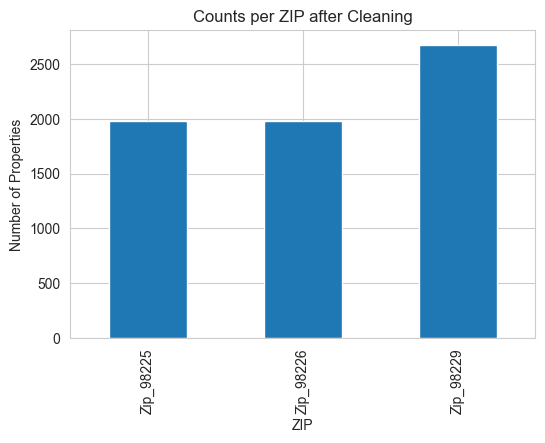

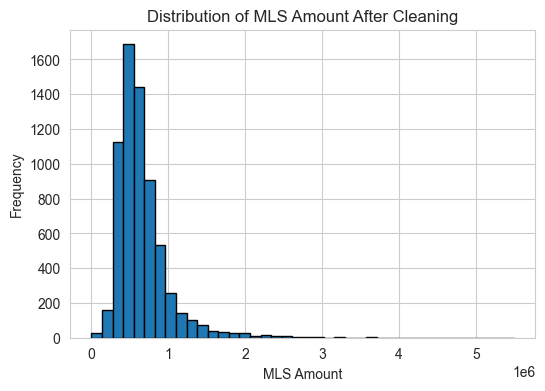

In [9]:
# Bar chart of counts per ZIP
zip_counts = zip_dummies.sum()
zip_counts.plot(kind="bar", figsize=(6,4))
plt.title("Counts per ZIP after Cleaning")
plt.ylabel("Number of Properties")
plt.xlabel("ZIP")
plt.show()

# Histogram of MLS Amount
df_cleaned["MLS Amount"].plot(kind="hist", bins=40, edgecolor="k", figsize=(6,4))
plt.title("Distribution of MLS Amount After Cleaning")
plt.xlabel("MLS Amount")
plt.show()

### 2.8 Outlier Detection

Boxplots and histograms revealed extreme values in key numeric fields
(`MLS Amount`, `Bedrooms`, `Sqft`, etc.). These may distort model training.
Visualizations below highlight the skew and long tails.

*Decision:* Outliers will be handled in the cleaning pipeline (IQR filtering).

### Outlier Detection and Removal (IQR Method)

To reduce noise and extreme distortions in the dataset, we applied **Interquartile Range (IQR) filtering** on key numeric features:

- **Method:** For each feature, values outside `Q1 - 1.5*IQR` and `Q3 + 1.5*IQR` were removed.
- **Scope:** Applied sequentially across `MLS Amount`, `Bedrooms`, `Total Bathrooms`, `Building Sqft`, `Lot Size Sqft`, and `Effective Year Built`.
- **Results:** Outlier rows were dropped, leading to a more stable dataset with reduced skew.
- **Visualization:** Before vs. After boxplots clearly show tighter distributions and fewer extreme outliers across all key features.

Rows before IQR filtering: 6,642
Rows after  IQR filtering: 5,205
Total reduction: 1,437 rows (21.6%)

Removed per feature during sequential filtering:
  MLS Amount: 364
  Bedrooms: 126
  Total Bathrooms: 12
  Building Sqft: 119
  Lot Size Sqft: 577
  Effective Year Built: 239


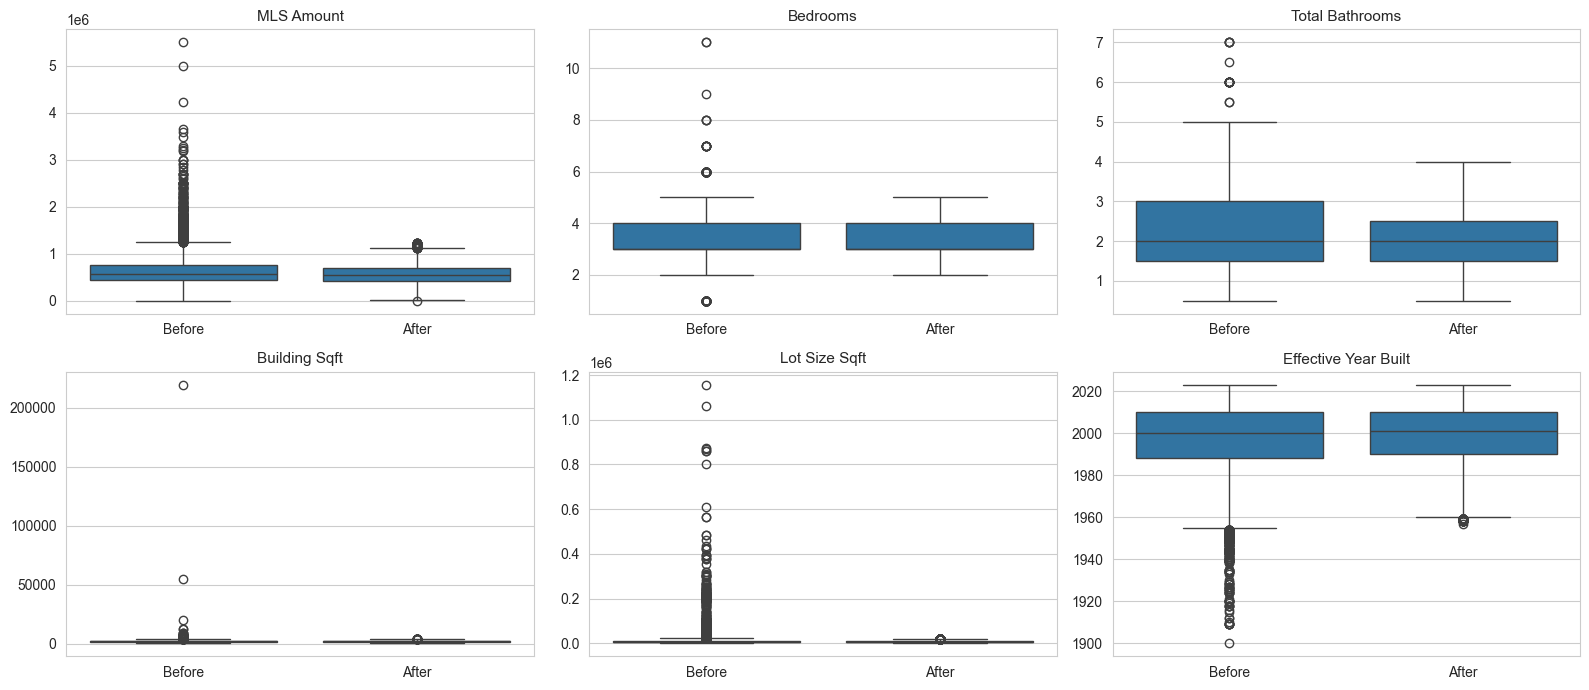

In [10]:
# ==== IQR Outlier Filtering + Before/After Boxplots ====
df_before = df_cleaned.copy()

# --- Numeric columns to check ---
num_cols = [
    "MLS Amount", "Bedrooms", "Total Bathrooms",
    "Building Sqft", "Lot Size Sqft", "Effective Year Built"
]

# --- IQR filtering (per column) ---
df_after = df_before.copy()
removed_counts = {}

for col in num_cols:
    Q1 = df_after[col].quantile(0.25)
    Q3 = df_after[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    n0 = len(df_after)
    df_after = df_after[(df_after[col] >= lower) & (df_after[col] <= upper)]
    removed_counts[col] = n0 - len(df_after)

rows_before = len(df_before)
rows_after  = len(df_after)
pct_reduction = 100 * (rows_before - rows_after) / rows_before if rows_before else 0

print(f"Rows before IQR filtering: {rows_before:,}")
print(f"Rows after  IQR filtering: {rows_after:,}")
print(f"Total reduction: {rows_before - rows_after:,} rows ({pct_reduction:.1f}%)")
print("\nRemoved per feature during sequential filtering:")
for k,v in removed_counts.items():
    print(f"  {k}: {v:,}")

# --- Before vs After boxplots ---
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 3, figsize=(16, 7))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    ax = axes[i]
    long_df = pd.DataFrame({
        "Group": (["Before"] * df_before.shape[0]) + (["After"] * df_after.shape[0]),
        "Value": pd.concat([df_before[col], df_after[col]], ignore_index=True)
    })
    sns.boxplot(data=long_df, x="Group", y="Value", ax=ax)
    ax.set_title(col, fontsize=11)
    ax.set_xlabel("")
    ax.set_ylabel("")

plt.tight_layout()
plt.show()

# Keep the filtered frame handy for later steps
df_cleaned = df_after.copy()

### 2.9 Duplicate Address Handling

To avoid bias from repeated property entries, we identified and removed duplicate rows based on the **`Address`** field:

- **Detection:** Found all rows with duplicate addresses and inspected frequency counts.
- **Action:** Retained the first occurrence of each address and dropped all subsequent duplicates.
- **Outcome:** Reduced dataset size by removing repeated property listings while ensuring unique address representation.
- **Sanity Check:** Confirmed no duplicate addresses remain in the cleaned dataset.

In [11]:
# 1) Boolean mask of duplicate addresses (True for all rows that have a duplicate)
dup_mask = df_cleaned["Address"].duplicated(keep=False)

# 2) How many and which addresses are duplicated?
dup_counts = (
    df_cleaned.loc[dup_mask, "Address"]
    .value_counts()
    .rename_axis("Address")
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)

print(f"Total rows: {len(df_cleaned)}")
print(f"Rows with duplicated Address: {dup_mask.sum()}")
print(f"Unique addresses that are duplicated: {dup_counts.shape[0]}\n")
print("Top duplicate addresses:")
print(dup_counts.head(20))

# 3) Preview the actual duplicate rows (address + a few helpful columns)
preview_cols = [c for c in ["Address","City","State","Zip","MLS Date","MLS Amount"] if c in df_cleaned.columns]
print("\nSample duplicate rows:")
print(df_cleaned.loc[dup_mask, preview_cols].head(20))

before = len(df_cleaned)
dup_rows = df_cleaned["Address"].duplicated(keep="first").sum()

# Drop duplicates by Address, keep the first occurrence
df_cleaned = df_cleaned.drop_duplicates(subset=["Address"], keep="first").reset_index(drop=True)

after = len(df_cleaned)

print(f"Rows before: {before}")
print(f"Duplicate address rows removed: {dup_rows}")
print(f"Rows after:  {after}")

# Sanity check: should be zero
remaining_dups = df_cleaned["Address"].duplicated(keep=False).sum()
print(f"Remaining duplicate-address rows: {remaining_dups}")

Total rows: 5205
Rows with duplicated Address: 4
Unique addresses that are duplicated: 2

Top duplicate addresses:
              Address  count
0  1 Sudden Valley Dr      2
1   1574 Brookedge Ct      2

Sample duplicate rows:
                 Address   MLS Date  MLS Amount
1126  1 Sudden Valley Dr 2021-03-01    389876.0
1255   1574 Brookedge Ct 2024-10-01    730000.0
1257   1574 Brookedge Ct 2024-10-01    710000.0
5634  1 Sudden Valley Dr 2020-10-01    365000.0
Rows before: 5205
Duplicate address rows removed: 2
Rows after:  5203
Remaining duplicate-address rows: 0


In [12]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5203 entries, 0 to 5202
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   MLS Amount            5203 non-null   float64       
 1   Address               5203 non-null   string        
 2   Bedrooms              5203 non-null   float64       
 3   Total Bathrooms       5203 non-null   float64       
 4   Building Sqft         5203 non-null   float64       
 5   Lot Size Sqft         5203 non-null   int64         
 6   Effective Year Built  5203 non-null   float64       
 7   MLS Date              5203 non-null   datetime64[ns]
 8   latitude              5203 non-null   float64       
 9   longitude             5203 non-null   float64       
 10  Zip_98225             5203 non-null   bool          
 11  Zip_98226             5203 non-null   bool          
 12  Zip_98229             5203 non-null   bool          
dtypes: bool(3), dateti

### 2.10 Post-Cleaning Assessment

After applying data cleaning steps — including column drops, type conversions, outlier filtering, and duplicate removal — the dataset is now in a more reliable state for modeling.

**Key Outcomes:**
- Removed irrelevant or high-missing-value columns (owner details, mailing info, loan estimates, etc.)
- Handled missing values and standardized data types (dates, booleans, ZIP codes as dummies)
- Filtered extreme outliers using IQR and domain-informed cutoffs to reduce noise
- Ensured each property address is unique by dropping duplicate listings

**Dataset Status:**
- Rows before cleaning: 7,001
- Rows after cleaning: 5,203
- Columns retained: 13
- Target variable (`MLS Amount`) preserved and validated for consistency

This cleaned dataset provides a strong foundation for exploratory data analysis (EDA), feature engineering, and predictive modeling.

# 3.0 Exploratory Data Analysis (EDA) Overview

This section explores the Bellingham housing dataset beyond basic summaries to surface structure, relationships, and potential modeling pitfalls. The analysis includes distribution checks, outlier diagnostics, correlation analysis, grouped price visualizations, statistical tests, and pairwise trend inspections.

---

## Summary Statistics
- Produced descriptive statistics for key numeric features (mean, median, quartiles, min/max).
- Helped identify skew (e.g., right-skew in price and sqft) and implausible values.
- Provided baseline expectations for feature scaling and model readiness.

---


## Histograms: Distributions of Key Numeric Features
- Displayed histograms for numeric variables.
- Confirmed right-skew in MLS Amount and Building Sqft.
- Suggested possible log transforms for modeling stability.

---

## Correlation Heatmap (Pearson)
- Built a lower-triangle heatmap ordered by absolute correlation with MLS Amount.
- Found strongest positive correlations with Building Sqft, Bathrooms, and Bedrooms.
- Noted mild negative correlation with longitude (west vs. east).

---

## Price Distributions by Categories
- **Bedrooms (Boxplot):** Price medians increase with bedroom count, but spread is wide.
- **Bathrooms (Boxplot):** Higher bath counts generally increase median price.
- **Year Buckets (Violin):** Newer homes show higher prices; older homes retain broader variance.
- **ZIP Codes (Barplot):** Median values vary significantly by neighborhood.

---

## Statistical Tests
- **ANOVA:** Found significant differences in mean prices across bedroom groups.
- **Welch’s t-test:** Showed newer homes (2000+) command statistically higher prices.
- **Mann–Whitney U:** Validated submarket differences across ZIP codes.

---

## Pairwise Relationships with Trendlines
- Scatterplots with regression lines confirmed positive trends:
  - Larger sqft → higher price.
  - Newer construction → higher price.
- Observed heteroskedasticity (wider spread at higher values).

---

## Log-Transform Distribution Checks
- Compared raw vs. log1p transformations of price and sqft.
- Log transform reduced skew and variance, supporting its use in linear models.

---

## Key Insights from EDA
- **Strong size and feature effects:** Building Sqft, Bedrooms, and Bathrooms are the most predictive base features.
- **Location matters:** Neighborhood/ZIP differences highlight spatial effects.
- **Skew/outliers:** Log transforms and outlier filtering improve statistical stability.
- **Market segmentation:** Newer vs. older homes show systematic value differences.

## 3.1 Summary Statistics

In [13]:
print("Summary statistics:\n")
print(df_cleaned.describe().T)

Summary statistics:

                       count                           mean  \
MLS Amount            5203.0                   584086.14876   
Bedrooms              5203.0                       3.236786   
Total Bathrooms       5203.0                       2.037046   
Building Sqft         5203.0                    1869.537382   
Lot Size Sqft         5203.0                    8131.379973   
Effective Year Built  5203.0                    1998.907938   
MLS Date                5203  2021-04-27 20:05:18.277916416   
latitude              5203.0                      48.751867   
longitude             5203.0                    -122.436447   

                                      min                  25%  \
MLS Amount                         1875.0             427000.0   
Bedrooms                              2.0                  3.0   
Total Bathrooms                       0.5                  1.5   
Building Sqft                       616.0               1387.5   
Lot Size Sqft     

## 3.2 Boxplots: Outlier Diagnostics

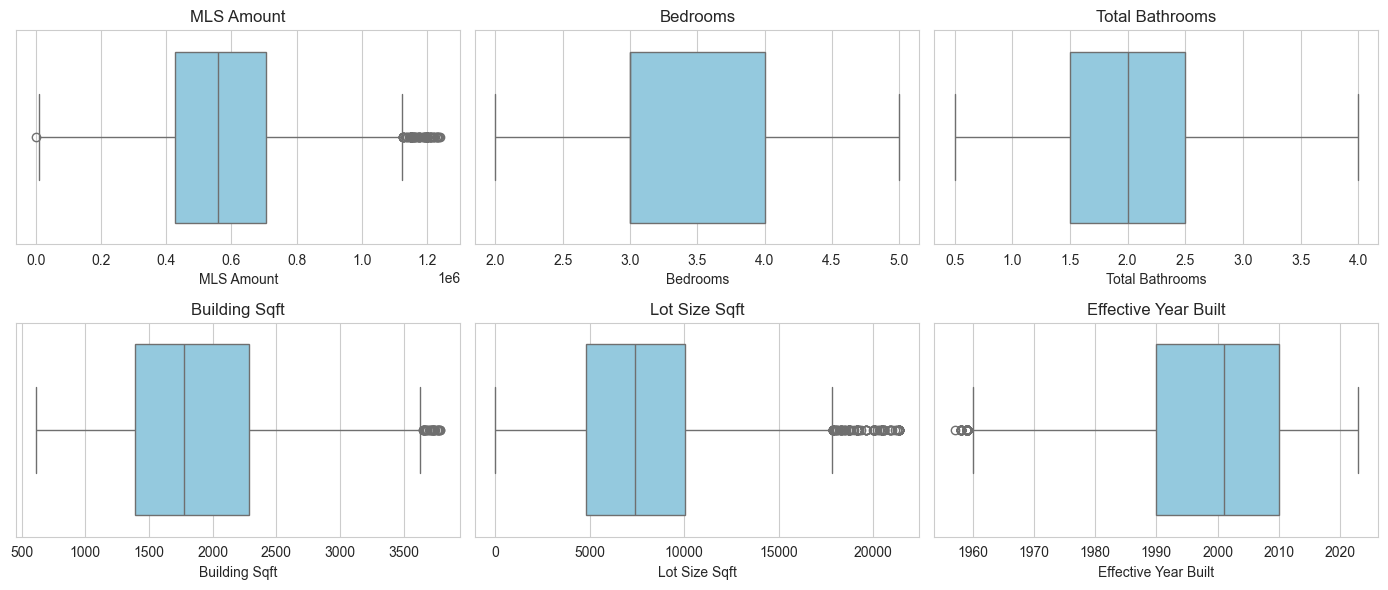

In [14]:
num_cols = [
    "MLS Amount","Bedrooms","Total Bathrooms","Building Sqft",
    "Lot Size Sqft","Effective Year Built"
]

plt.figure(figsize=(14,6))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=df_cleaned[col], color="skyblue")
    plt.title(col)
plt.tight_layout()
plt.show()

## 3.3 Histograms: Feature Distributions

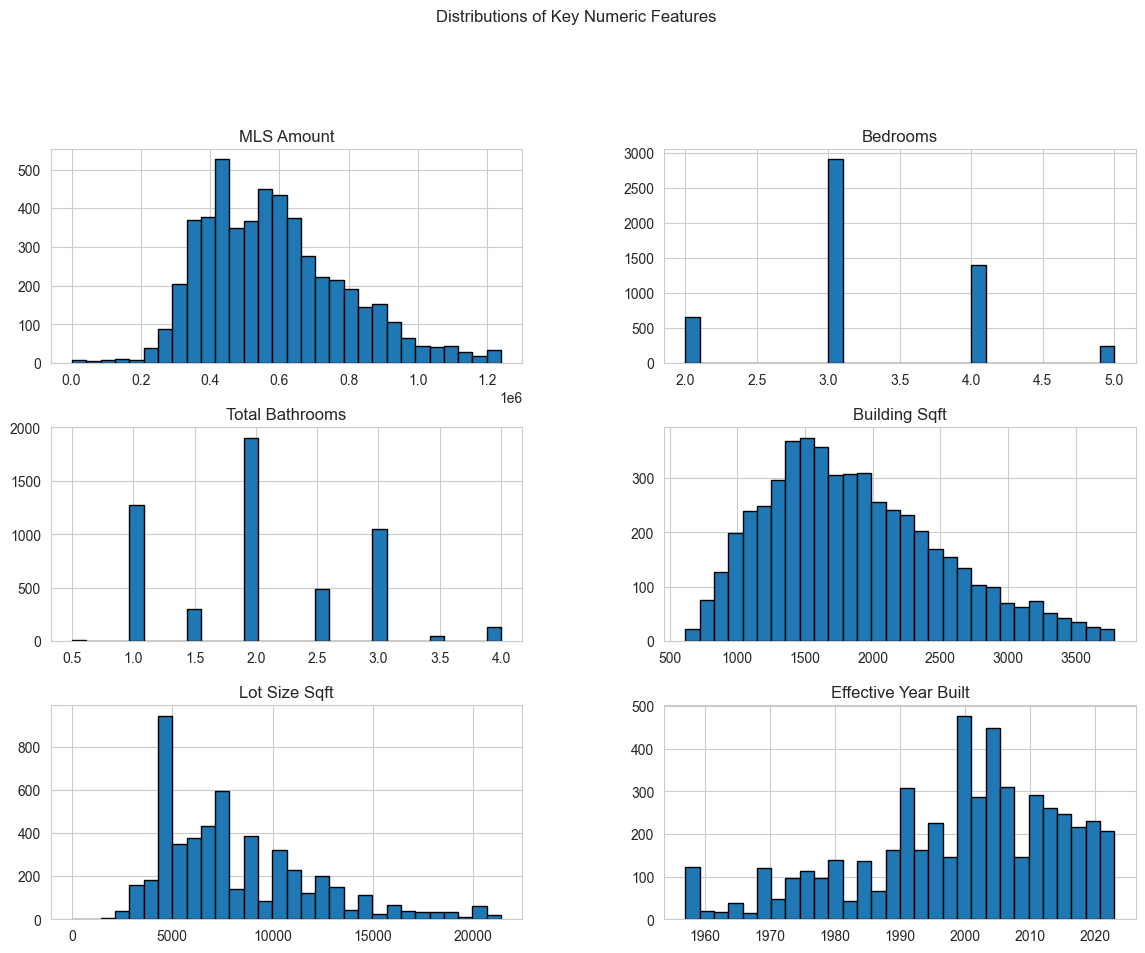

In [15]:
df_cleaned[num_cols].hist(bins=30, figsize=(14,10), edgecolor="black")
plt.suptitle("Distributions of Key Numeric Features", y=1.02)
plt.show()

## 3.4 Boolean Features Overview

Boolean columns: ['Zip_98225', 'Zip_98226', 'Zip_98229']

Zip_98225:
           count  proportion
Zip_98225                   
False       3788    0.728042
True        1415    0.271958

Zip_98226:
           count  proportion
Zip_98226                   
False       3675    0.706323
True        1528    0.293677

Zip_98229:
           count  proportion
Zip_98229                   
False       2943    0.565635
True        2260    0.434365


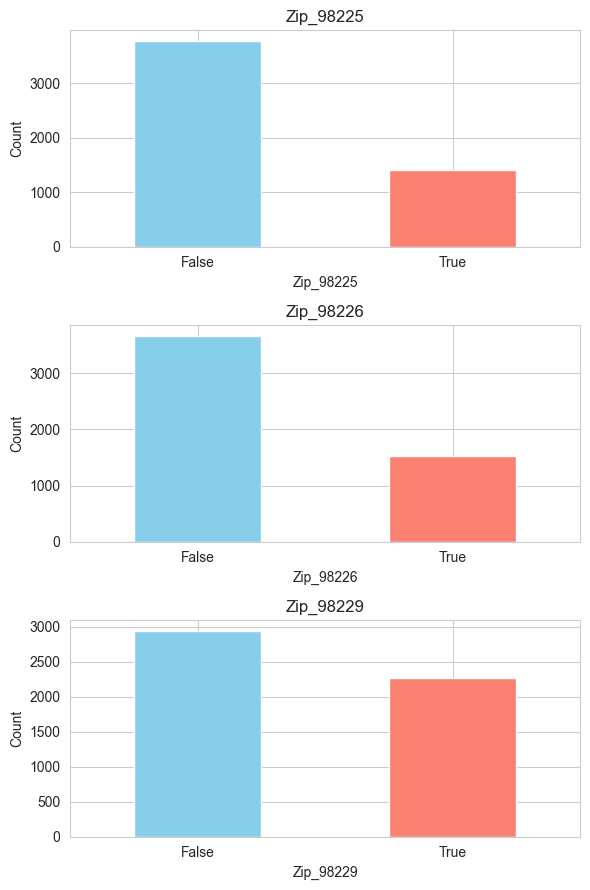

In [16]:
bool_cols = df_cleaned.select_dtypes(include=["bool"]).columns.tolist()
print("Boolean columns:", bool_cols)

for col in bool_cols:
    counts = df_cleaned[col].value_counts(dropna=False)
    props = df_cleaned[col].value_counts(normalize=True, dropna=False)
    print(f"\n{col}:")
    print(pd.DataFrame({"count": counts, "proportion": props}))

plt.figure(figsize=(6, 3 * len(bool_cols)))
for i, col in enumerate(bool_cols, 1):
    plt.subplot(len(bool_cols), 1, i)
    df_cleaned[col].value_counts().plot(kind="bar", color=["skyblue", "salmon"])
    plt.title(col)
    plt.ylabel("Count")
    plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## 3.5 Grouped Price Distributions

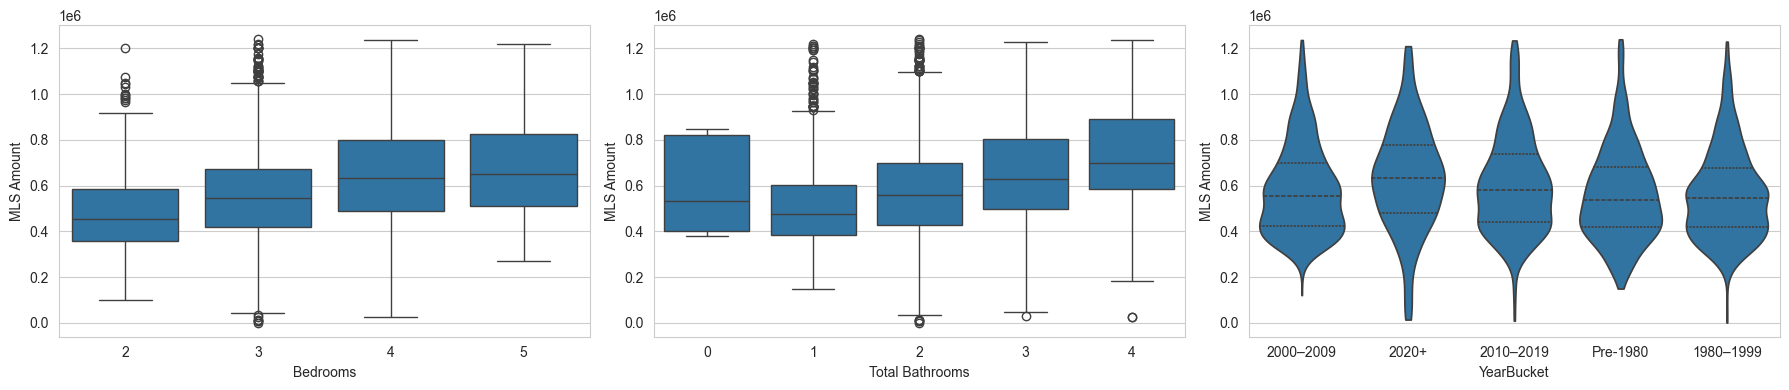

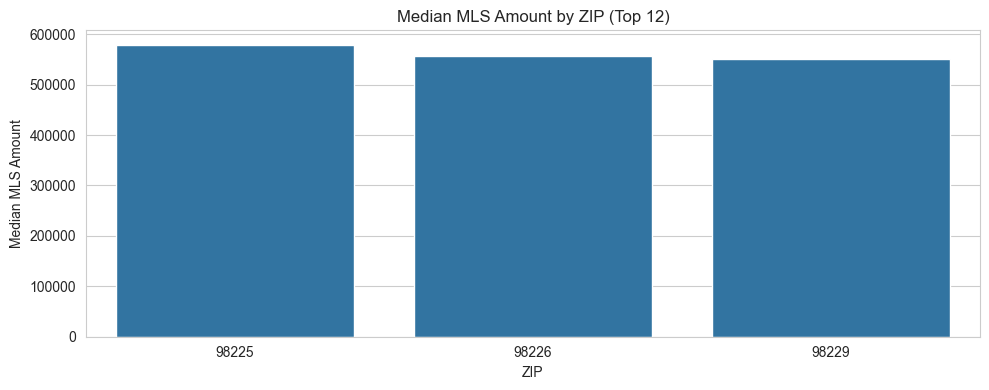

In [17]:
eda = df_cleaned.copy()

# Bedrooms/Bathrooms as integers
for c in ["Bedrooms", "Total Bathrooms"]:
    if c in eda.columns:
        eda[c] = pd.to_numeric(eda[c], errors="coerce").round().astype("Int64")

# Year buckets from Effective Year Built
def year_bucket(y):
    y = pd.to_numeric(y, errors="coerce")
    if pd.isna(y):
        return pd.NA
    if y < 1980:   return "Pre-1980"
    if y < 2000:   return "1980–1999"
    if y < 2010:   return "2000–2009"
    if y < 2020:   return "2010–2019"
    return "2020+"

if "Effective Year Built" in eda.columns:
    eda["YearBucket"] = eda["Effective Year Built"].map(year_bucket)
else:
    eda["YearBucket"] = pd.NA

# ZIP category from one-hot columns (Zip_XXXXX)
zip_cols = [c for c in eda.columns if c.startswith("Zip_")]
if zip_cols:
    # choose the active one-hot column per row
    zidx = eda[zip_cols].astype(int).idxmax(axis=1)
    # rows with all-zeros become NaN; handle that
    zallzero = eda[zip_cols].sum(axis=1) == 0
    eda["ZIP"] = zidx.str.replace("Zip_", "", regex=False)
    eda.loc[zallzero, "ZIP"] = pd.NA
else:
    eda["ZIP"] = pd.NA

fig, axes = plt.subplots(1, 3, figsize=(18, 4))
sns.boxplot(data=eda, x="Bedrooms", y="MLS Amount", ax=axes[0])
sns.boxplot(data=eda, x="Total Bathrooms", y="MLS Amount", ax=axes[1])
sns.violinplot(data=eda, x="YearBucket", y="MLS Amount", ax=axes[2], cut=0, inner="quartile")
plt.tight_layout()
plt.show()

# Median by ZIP
if eda["ZIP"].notna().any():
    zip_summary = (
        eda.dropna(subset=["ZIP"])
           .groupby("ZIP")["MLS Amount"].median()
           .sort_values(ascending=False)
           .head(12)
    )
    plt.figure(figsize=(10,4))
    sns.barplot(x=zip_summary.index, y=zip_summary.values)
    plt.title("Median MLS Amount by ZIP (Top 12)")
    plt.xlabel("ZIP")
    plt.ylabel("Median MLS Amount")
    plt.tight_layout()
    plt.show()

## 3.6 Statistical Tests

In [18]:
# --- ANOVA: Do mean prices differ by Bedrooms? ---
if "Bedrooms" in eda.columns:
    eda["Bedrooms_int"] = pd.to_numeric(eda["Bedrooms"], errors="coerce").round().astype("Int64")
    groups = [g["MLS Amount"].dropna().values
              for _, g in eda.dropna(subset=["Bedrooms_int"]).groupby("Bedrooms_int")]
    groups = [g for g in groups if len(g) > 2]  # need > 2 samples
    if len(groups) >= 2:
        F, p = stats.f_oneway(*groups)
        print(f"ANOVA (MLS Amount by Bedrooms): F={F:.3f}, p={p:.4g}")
    else:
        print("ANOVA skipped (not enough groups for Bedrooms).")

# --- Welch’s t-test: Newer (>=2000) vs Older (<2000) ---
if "Effective Year Built" in eda.columns:
    newer = eda.loc[pd.to_numeric(eda["Effective Year Built"], errors="coerce") >= 2000, "MLS Amount"].dropna()
    older = eda.loc[pd.to_numeric(eda["Effective Year Built"], errors="coerce") < 2000, "MLS Amount"].dropna()
    if len(newer) > 10 and len(older) > 10:
        t, p = stats.ttest_ind(newer, older, equal_var=False)  # Welch's
        print(f"Welch t-test (Price: Newer>=2000 vs Older<2000): t={t:.3f}, p={p:.4g}")
        print(f"Means: newer={newer.mean():.0f}, older={older.mean():.0f}")
    else:
        print("t-test skipped (insufficient samples).")

ANOVA (MLS Amount by Bedrooms): F=153.556, p=2.341e-95
Welch t-test (Price: Newer>=2000 vs Older<2000): t=6.084, p=1.26e-09
Means: newer=598673, older=564001


## 3.7 Pairwise Relationships with Trendlines

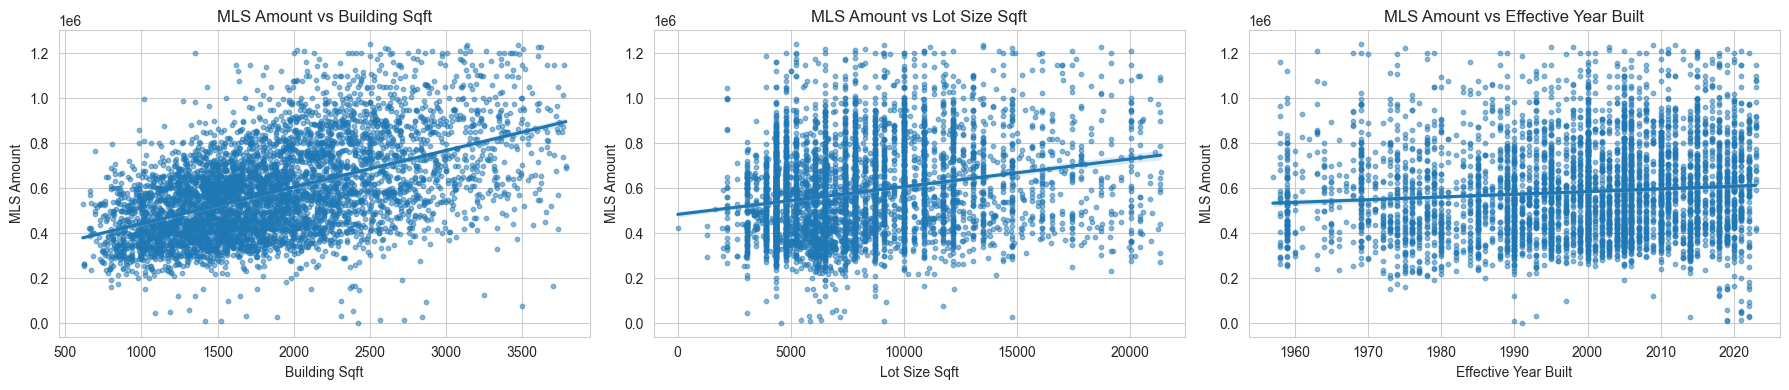

In [19]:
pairs = [
    ("Building Sqft", "MLS Amount"),
    ("Lot Size Sqft", "MLS Amount"),
    ("Effective Year Built", "MLS Amount"),
]

fig, axes = plt.subplots(1, len(pairs), figsize=(18, 4))
for ax, (xcol, ycol) in zip(axes, pairs):
    dfp = df_cleaned[[xcol, ycol]].dropna()
    if dfp.empty:
        ax.set_visible(False)
        continue
    sns.regplot(data=dfp, x=xcol, y=ycol, scatter_kws={"s": 10, "alpha": 0.5}, ax=ax)
    ax.set_title(f"{ycol} vs {xcol}")
plt.tight_layout()
plt.show()

## 3.8 Log-Transform Checks

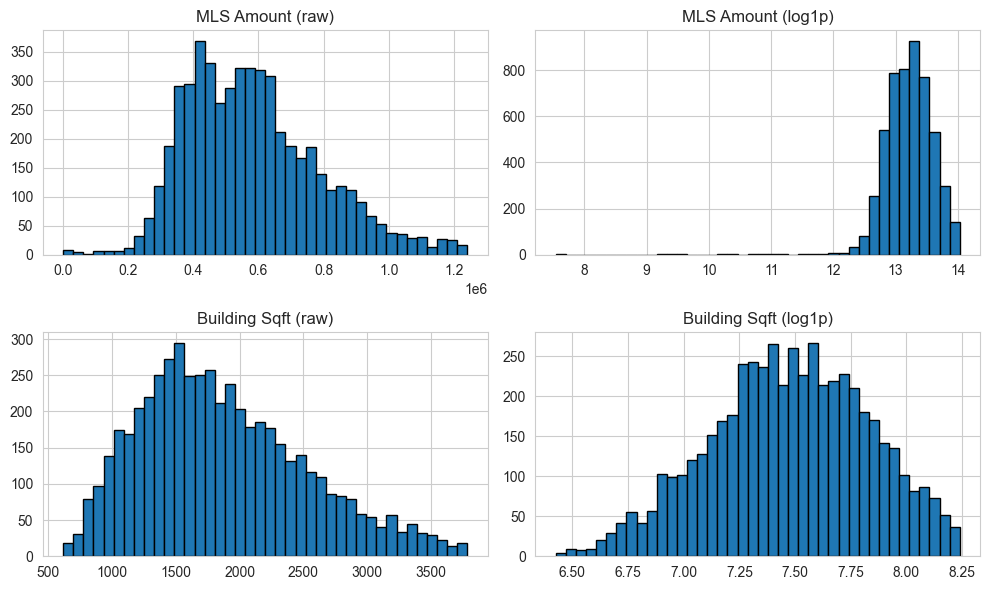

In [20]:
cols = ["MLS Amount", "Building Sqft"]
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

for i, col in enumerate(cols):
    axes[i,0].hist(df_cleaned[col].dropna(), bins=40, edgecolor="black")
    axes[i,0].set_title(f"{col} (raw)")
    axes[i,1].hist(np.log1p(df_cleaned[col].dropna()), bins=40, edgecolor="black")
    axes[i,1].set_title(f"{col} (log1p)")

plt.tight_layout()
plt.show()

## 3.9 Correlation Heatmap

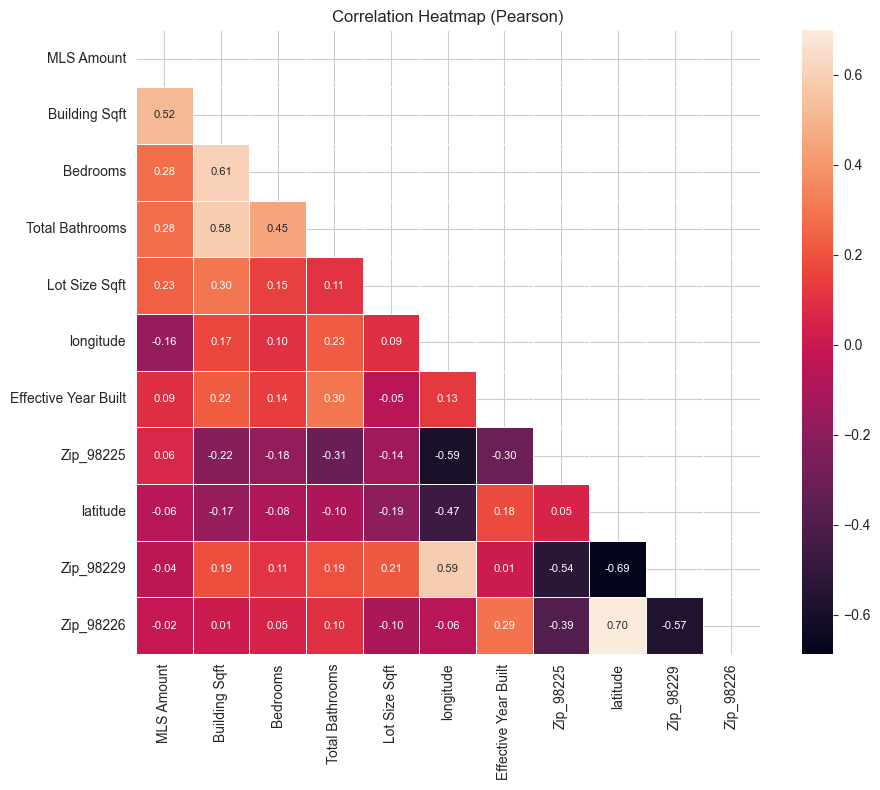


Top correlations with MLS Amount:
Building Sqft           0.517744
Bedrooms                0.280310
Total Bathrooms         0.278782
Lot Size Sqft           0.233079
longitude              -0.161125
Effective Year Built    0.091104
Zip_98225               0.064471
latitude               -0.060027
Zip_98229              -0.039217
Zip_98226              -0.020307


In [21]:
# 1) Select numeric features (treat bools as ints)
df_num = df_cleaned.select_dtypes(include=["number", "bool"]).copy()
for c in df_num.select_dtypes(include=["bool"]).columns:
    df_num[c] = df_num[c].astype(int)

# 2) Drop zero-variance cols (avoid NaNs in corr)
zero_var = df_num.columns[df_num.nunique(dropna=False) <= 1]
if len(zero_var):
    print("Dropping zero-variance columns from correlation:", zero_var.tolist())
    df_num = df_num.drop(columns=zero_var)

# 3) Compute Pearson correlation
corr = df_num.corr(method="pearson")

# 4) Order by absolute correlation with target (if present)
TARGET = "MLS Amount"
if TARGET in corr.columns:
    order = corr[TARGET].abs().sort_values(ascending=False).index.tolist()
    corr = corr.loc[order, order]

# 5) Classic seaborn heatmap (square cells, annotations, masked upper triangle)
mask = np.triu(np.ones_like(corr, dtype=bool))  # hide duplicate upper half

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    fmt=".2f",
    square=True,
    cbar=True,
    linewidths=0.5,
    annot_kws={"size": 8}
)
plt.title("Correlation Heatmap (Pearson)")
plt.tight_layout()
plt.show()

# 6) Also print top correlations with the target
if TARGET in corr.columns:
    print("\nTop correlations with MLS Amount:")
    print(
        corr[TARGET]
        .drop(TARGET)
        .sort_values(key=lambda s: s.abs(), ascending=False)
        .head(12)
        .to_string()
    )

### Key Takeaways from Correlation Analysis

- **Size matters most:** `Building Sqft` shows the strongest correlation with price (`r ≈ 0.51`), confirming that larger homes generally command higher values.
- **Bathrooms and bedrooms matter too:** `Total Bathrooms` (`r ≈ 0.27`) and `Bedrooms` (`r ≈ 0.27`) are moderately correlated with price, indicating interior livability is a major driver of value.
- **Location has weaker signal in this dataset:** Geographic coordinates (latitude/longitude) and lot size show relatively low correlations (`|r| < 0.17`), suggesting that location and land factors may require more advanced spatial features (e.g., neighborhood comps) to capture their impact.

# 4.0 Feature Engineering Summary (Core + Bellingham Geo)


---

## 1) Core Property Features

- **Property_Age** = `CURRENT_YEAR` − *Effective Year Built*
  *Rationale:* Depreciation/renovation proxy; captures vintage effects.

- **Ratios / Densities**
  - `Lot_Efficiency` = Building Sqft ÷ Lot Size Sqft
  - `Sqft_per_Bedroom` = Building Sqft ÷ Bedrooms
  - `Sqft_per_Bathroom` = Building Sqft ÷ Total Bathrooms
  - `Bedroom_Bath_Ratio` = Bedrooms ÷ Total Bathrooms
  - `Luxury_Score` = Total Bathrooms ÷ Bedrooms
  *Rationale:* Normalize for size, bedrooms/baths mix; signal layout intensity and amenity density.

- **Log Transforms**
  - `Building_Sqft_log`, `Lot_Size_Sqft_log`, `Property_Age_log` via `log1p`
  *Rationale:* Reduce skew and tame long tails; stabilizes linear/model splits.

- **Market Recency & Seasonality**
  - `Days_Since_Sold`, `Years_Since_Sold` from an `ANCHOR_DATE`
  - `MLS_Month` (1–12) and `Season_*` (Winter/Spring/Summer/Fall one-hots)
  *Rationale:* Temporal drift and seasonality in housing demand.

- **Binary Flags**
  - `Large_Lot_Flag`, `Large_House_Flag`, `Premium_Property` (≥4 bed, ≥3 bath, big lot)
  *Rationale:* Nonlinear thresholds for “step-up” effects.

- **Interactions**
  - `Age_Size_Interaction` = Property_Age × Building Sqft
  - `Bedroom_Bath_Efficiency` = (Bedrooms + Total Bathrooms) ÷ Building Sqft
  *Rationale:* Simple pairwise interactions that often matter in price.

---

## 2) Bellingham Geo Features

- **Distances (miles) to landmarks**
  - `dist_to_downtown_mi`, `dist_to_wwu_mi`, `dist_to_fairhaven_mi`, `dist_to_airport_mi`, `dist_to_bellis_mi`
  - Nearest I-5 interchange distance: `dist_to_i5_nearest_mi`
  - Shore proximity: `dist_to_lake_whatcom_mi` (min of sampled shore points)
  *Rationale:* Accessibility, amenities, and desirability gradients.

- **Directional Context**
  - `bearing_to_downtown_deg` and `sector_to_downtown_*` (N/NE/E/SE/S/SW/W/NW one-hots)
  *Rationale:* Captures quadrant effects (e.g., east of downtown vs. west).

- **Proximity Threshold Flags (nonlinear effects)**
  - `within_{r}_mi_downtown`, `within_{r}_mi_i5`, `within_{r}_mi_lake`, `within_{r}_mi_wwu` for *r* ∈ {0.5, 1.0, 2.0, 3.0}
  *Rationale:* Step-changes near important amenities/barriers.

- **Spatial Trend Terms**
  - `lat_z`, `lon_z` (z-scores)
  *Rationale:* Low-order spatial trend for linear models; helps absorb broad location drift.

---

## 3) Data Hygiene & Safety

- **Safe Division:** All ratio features use a `safe_div` helper (coerce → float; inf → NaN).
- **Coordinates:** `latitude`/`longitude` coerced to float; distances via Haversine.
- **One-Hots:** Season and sector dummies use consistent prefixes for clean modeling.
- **Leakage Guard:** No target (`MLS Amount`) used in any engineered feature; time-based features reference a fixed `ANCHOR_DATE`, not label information.


In [22]:
# ---------- Base copy ----------
df_fe = df_cleaned.copy()
_start_cols = df_fe.columns.tolist()

# ---------- Helpers ----------
def safe_div(a, b):
    a = pd.to_numeric(a, errors="coerce")
    b = pd.to_numeric(b, errors="coerce")
    out = a / b
    out.replace([np.inf, -np.inf], np.nan, inplace=True)
    return out

def haversine_np(lat1, lon1, lat2, lon2):
    # inputs: arrays (lat1, lon1) & scalars lat2, lon2 (degrees) -> miles
    lat1 = np.radians(pd.to_numeric(lat1, errors="coerce").astype(float))
    lon1 = np.radians(pd.to_numeric(lon1, errors="coerce").astype(float))
    lat2 = np.radians(float(lat2))
    lon2 = np.radians(float(lon2))
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    R_mi = 3956.0
    return R_mi * c

def bearing_np(lat1, lon1, lat2, lon2):
    lat1r = np.radians(pd.to_numeric(lat1, errors="coerce").astype(float))
    lon1r = np.radians(pd.to_numeric(lon1, errors="coerce").astype(float))
    lat2r = np.radians(float(lat2))
    lon2r = np.radians(float(lon2))
    dlon = lon2r - lon1r
    y = np.sin(dlon) * np.cos(lat2r)
    x = np.cos(lat1r)*np.sin(lat2r) - np.sin(lat1r)*np.cos(lat2r)*np.cos(dlon)
    brng = np.degrees(np.arctan2(y, x))
    return (brng + 360) % 360

def sector8_from_bearing(arr_deg):
    sectors = np.array(["N","NE","E","SE","S","SW","W","NW"])
    idx = ((arr_deg + 22.5) // 45).astype(int) % 8
    return sectors[idx]

# ---------- 1) Core features ----------
CURRENT_YEAR = 2025  # <- adjust once and everything updates
df_fe["Property_Age"] = CURRENT_YEAR - df_fe["Effective Year Built"]

# Ratios / densities
df_fe["Lot_Efficiency"]      = safe_div(df_fe["Building Sqft"], df_fe["Lot Size Sqft"])
df_fe["Sqft_per_Bedroom"]    = safe_div(df_fe["Building Sqft"], df_fe["Bedrooms"])
df_fe["Sqft_per_Bathroom"]   = safe_div(df_fe["Building Sqft"], df_fe["Total Bathrooms"])
df_fe["Bedroom_Bath_Ratio"]  = safe_div(df_fe["Bedrooms"], df_fe["Total Bathrooms"])
df_fe["Luxury_Score"]        = safe_div(df_fe["Total Bathrooms"], df_fe["Bedrooms"])

# Logs for skew
for col in ["Building Sqft", "Lot Size Sqft", "Property_Age"]:
    df_fe[f"{col.replace(' ', '_')}_log"] = np.log1p(pd.to_numeric(df_fe[col], errors="coerce").clip(lower=0))

# Market recency + seasonality
ANCHOR_DATE = pd.Timestamp("2026-01-01")  # one anchor for time-based features
df_fe["Days_Since_Sold"]  = (ANCHOR_DATE - df_fe["MLS Date"]).dt.days
df_fe["Years_Since_Sold"] = df_fe["Days_Since_Sold"] / 365.25
df_fe["MLS_Month"]        = df_fe["MLS Date"].dt.month
# Simple season labels
season_map = {12:"Winter",1:"Winter",2:"Winter",3:"Spring",4:"Spring",5:"Spring",6:"Summer",7:"Summer",8:"Summer",9:"Fall",10:"Fall",11:"Fall"}
df_fe["MLS_Season"] = df_fe["MLS_Month"].map(season_map)
df_fe = pd.get_dummies(df_fe, columns=["MLS_Season"], prefix="Season", dtype=bool)

# Flags
df_fe["Large_Lot_Flag"]   = (df_fe["Lot Size Sqft"] > 10000).astype(int)
df_fe["Large_House_Flag"] = (df_fe["Building Sqft"] > 3000).astype(int)
df_fe["Premium_Property"] = ((df_fe["Bedrooms"] >= 4) & (df_fe["Total Bathrooms"] >= 3) & (df_fe["Lot Size Sqft"] > 15000)).astype(int)

# Interactions
df_fe["Age_Size_Interaction"]     = pd.to_numeric(df_fe["Property_Age"], errors="coerce") * pd.to_numeric(df_fe["Building Sqft"], errors="coerce")
df_fe["Bedroom_Bath_Efficiency"]  = safe_div(df_fe["Bedrooms"] + df_fe["Total Bathrooms"], df_fe["Building Sqft"])

# ---------- 2) Bellingham geo features ----------
# Ensure numeric lat/lon
for c in ["latitude","longitude"]:
    df_fe[c] = pd.to_numeric(df_fe[c], errors="coerce").astype(float)

# Landmarks (approx)
BELLINGHAM_CENTER = (48.7519, -122.4787)  # City Hall / downtown
WWU        = (48.7345, -122.4869)
FAIRHAVEN  = (48.7204, -122.5053)
BLI_AIRPORT= (48.7964, -122.5375)
BELLIS_FAIR= (48.7873, -122.4895)

I5_POINTS = {
    "I5_Bakerview": (48.8016, -122.5083),
    "I5_Meridian":  (48.7779, -122.4892),
    "I5_Lakeway":   (48.7473, -122.4576),
    "I5_Samish":    (48.7248, -122.4516),
}
LAKE_WHATCOM = [
    (48.7408, -122.3994),
    (48.6966, -122.3737),
    (48.6633, -122.3240),
]

# Distances to landmarks
df_fe["dist_to_downtown_mi"]  = haversine_np(df_fe["latitude"], df_fe["longitude"], *BELLINGHAM_CENTER)
df_fe["dist_to_wwu_mi"]       = haversine_np(df_fe["latitude"], df_fe["longitude"], *WWU)
df_fe["dist_to_fairhaven_mi"] = haversine_np(df_fe["latitude"], df_fe["longitude"], *FAIRHAVEN)
df_fe["dist_to_airport_mi"]   = haversine_np(df_fe["latitude"], df_fe["longitude"], *BLI_AIRPORT)
df_fe["dist_to_bellis_mi"]    = haversine_np(df_fe["latitude"], df_fe["longitude"], *BELLIS_FAIR)

# Nearest I-5 interchange
for name, (ilat, ilon) in I5_POINTS.items():
    df_fe[f"dist_{name}_mi"] = haversine_np(df_fe["latitude"], df_fe["longitude"], ilat, ilon)
i5_cols = [c for c in df_fe.columns if c.startswith("dist_I5_")]
df_fe["dist_to_i5_nearest_mi"] = df_fe[i5_cols].min(axis=1) if i5_cols else np.nan

# Min distance to Lake Whatcom (shore samples)
if len(LAKE_WHATCOM):
    lake_stack = np.vstack([haversine_np(df_fe["latitude"], df_fe["longitude"], lat, lon) for (lat, lon) in LAKE_WHATCOM])
    df_fe["dist_to_lake_whatcom_mi"] = lake_stack.min(axis=0)

# Bearing + sectors
df_fe["bearing_to_downtown_deg"] = bearing_np(df_fe["latitude"], df_fe["longitude"], *BELLINGHAM_CENTER)
df_fe["sector_to_downtown"] = sector8_from_bearing(df_fe["bearing_to_downtown_deg"].values)
df_fe = pd.get_dummies(df_fe, columns=["sector_to_downtown"], prefix="sector", dtype=bool)

# Proximity flags (nonlinear thresholds)
for r in [0.5, 1.0, 2.0, 3.0]:
    df_fe[f"within_{r}_mi_downtown"] = (df_fe["dist_to_downtown_mi"] <= r).astype(int)
    df_fe[f"within_{r}_mi_i5"]       = (df_fe["dist_to_i5_nearest_mi"] <= r).astype(int)
    df_fe[f"within_{r}_mi_lake"]     = (df_fe["dist_to_lake_whatcom_mi"] <= r).astype(int)
    df_fe[f"within_{r}_mi_wwu"]      = (df_fe["dist_to_wwu_mi"] <= r).astype(int)

# Simple spatial trend terms for linear models
df_fe["lat_z"] = (df_fe["latitude"] - df_fe["latitude"].mean()) / df_fe["latitude"].std(ddof=0)
df_fe["lon_z"] = (df_fe["longitude"] - df_fe["longitude"].mean()) / df_fe["longitude"].std(ddof=0)


# ---------- 3) Report what we added ----------
_added = [c for c in df_fe.columns if c not in _start_cols]
print(f"✅ Engineered {len(_added)} new features.")

# Copy/paste list
print("\n# Copy/paste list of added features:")
print("[" + ", ".join(repr(c) for c in sorted(_added)) + "]")

# Quick peek
peek_cols = [c for c in [
    "Property_Age","Lot_Efficiency","Sqft_per_Bedroom","Luxury_Score",
    "Building_Sqft_log","Lot_Size_Sqft_log","Property_Age_log",
    "Days_Since_Sold","Years_Since_Sold","Season_Fall","Season_Summer",
    "Large_Lot_Flag","Age_Size_Interaction","Bedroom_Bath_Efficiency",
    "dist_to_downtown_mi","dist_to_wwu_mi","dist_to_lake_whatcom_mi",
    "dist_to_i5_nearest_mi","bearing_to_downtown_deg","lat_z","lon_z",
    "within_1.0_mi_downtown","within_2.0_mi_lake"
] if c in df_fe.columns]
print("\nPeek:\n", df_fe[peek_cols].head(3))

✅ Engineered 58 new features.

# Copy/paste list of added features:
['Age_Size_Interaction', 'Bedroom_Bath_Efficiency', 'Bedroom_Bath_Ratio', 'Building_Sqft_log', 'Days_Since_Sold', 'Large_House_Flag', 'Large_Lot_Flag', 'Lot_Efficiency', 'Lot_Size_Sqft_log', 'Luxury_Score', 'MLS_Month', 'Premium_Property', 'Property_Age', 'Property_Age_log', 'Season_Fall', 'Season_Spring', 'Season_Summer', 'Season_Winter', 'Sqft_per_Bathroom', 'Sqft_per_Bedroom', 'Years_Since_Sold', 'bearing_to_downtown_deg', 'dist_I5_Bakerview_mi', 'dist_I5_Lakeway_mi', 'dist_I5_Meridian_mi', 'dist_I5_Samish_mi', 'dist_to_airport_mi', 'dist_to_bellis_mi', 'dist_to_downtown_mi', 'dist_to_fairhaven_mi', 'dist_to_i5_nearest_mi', 'dist_to_lake_whatcom_mi', 'dist_to_wwu_mi', 'lat_z', 'lon_z', 'sector_N', 'sector_NE', 'sector_NW', 'sector_S', 'sector_SE', 'sector_SW', 'sector_W', 'within_0.5_mi_downtown', 'within_0.5_mi_i5', 'within_0.5_mi_lake', 'within_0.5_mi_wwu', 'within_1.0_mi_downtown', 'within_1.0_mi_i5', 'within_1.0

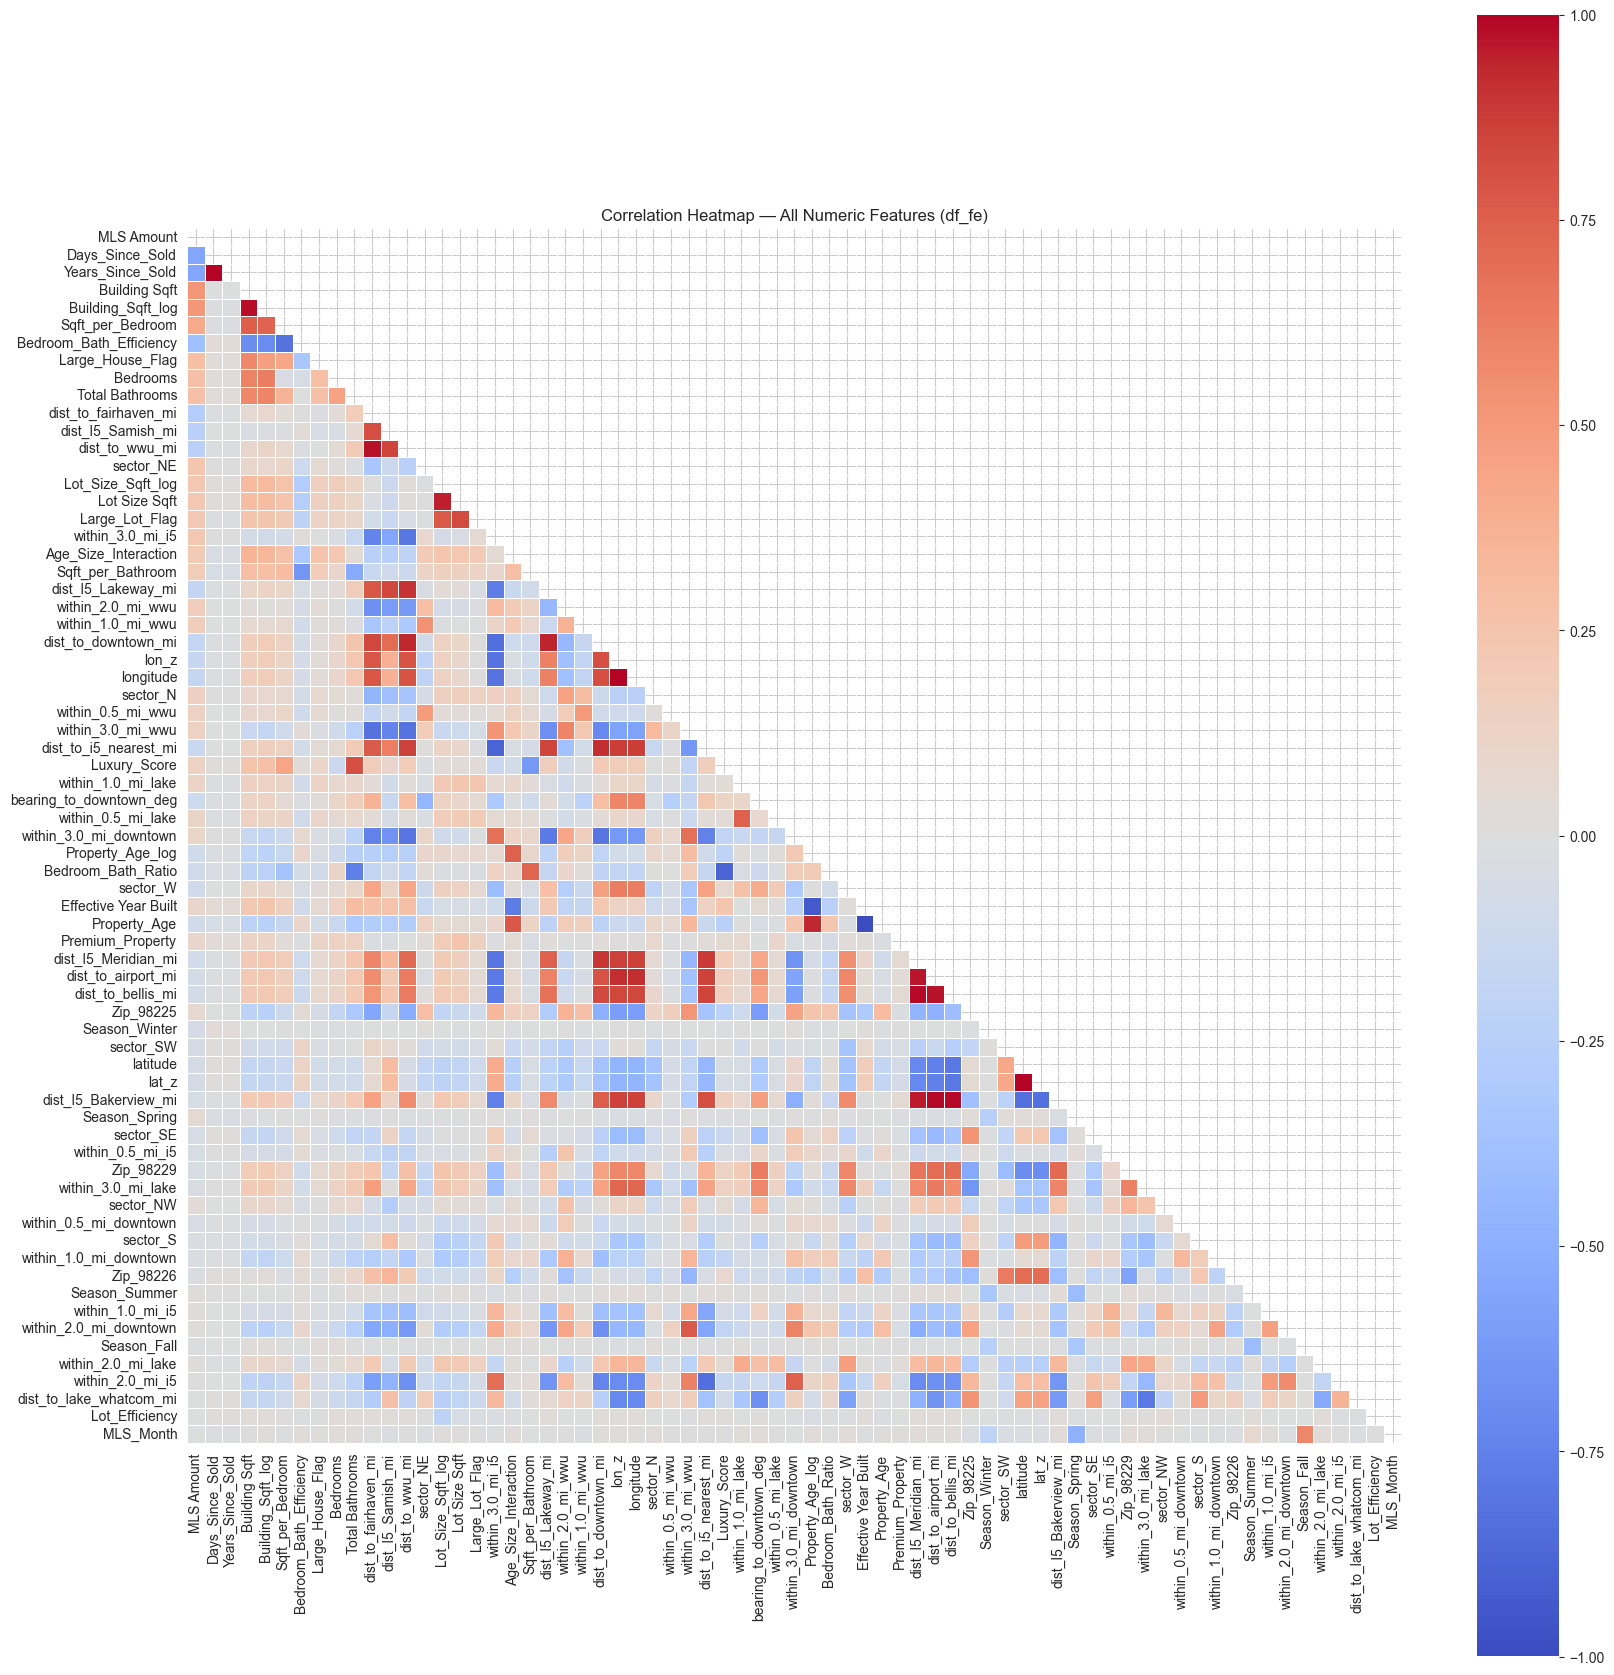

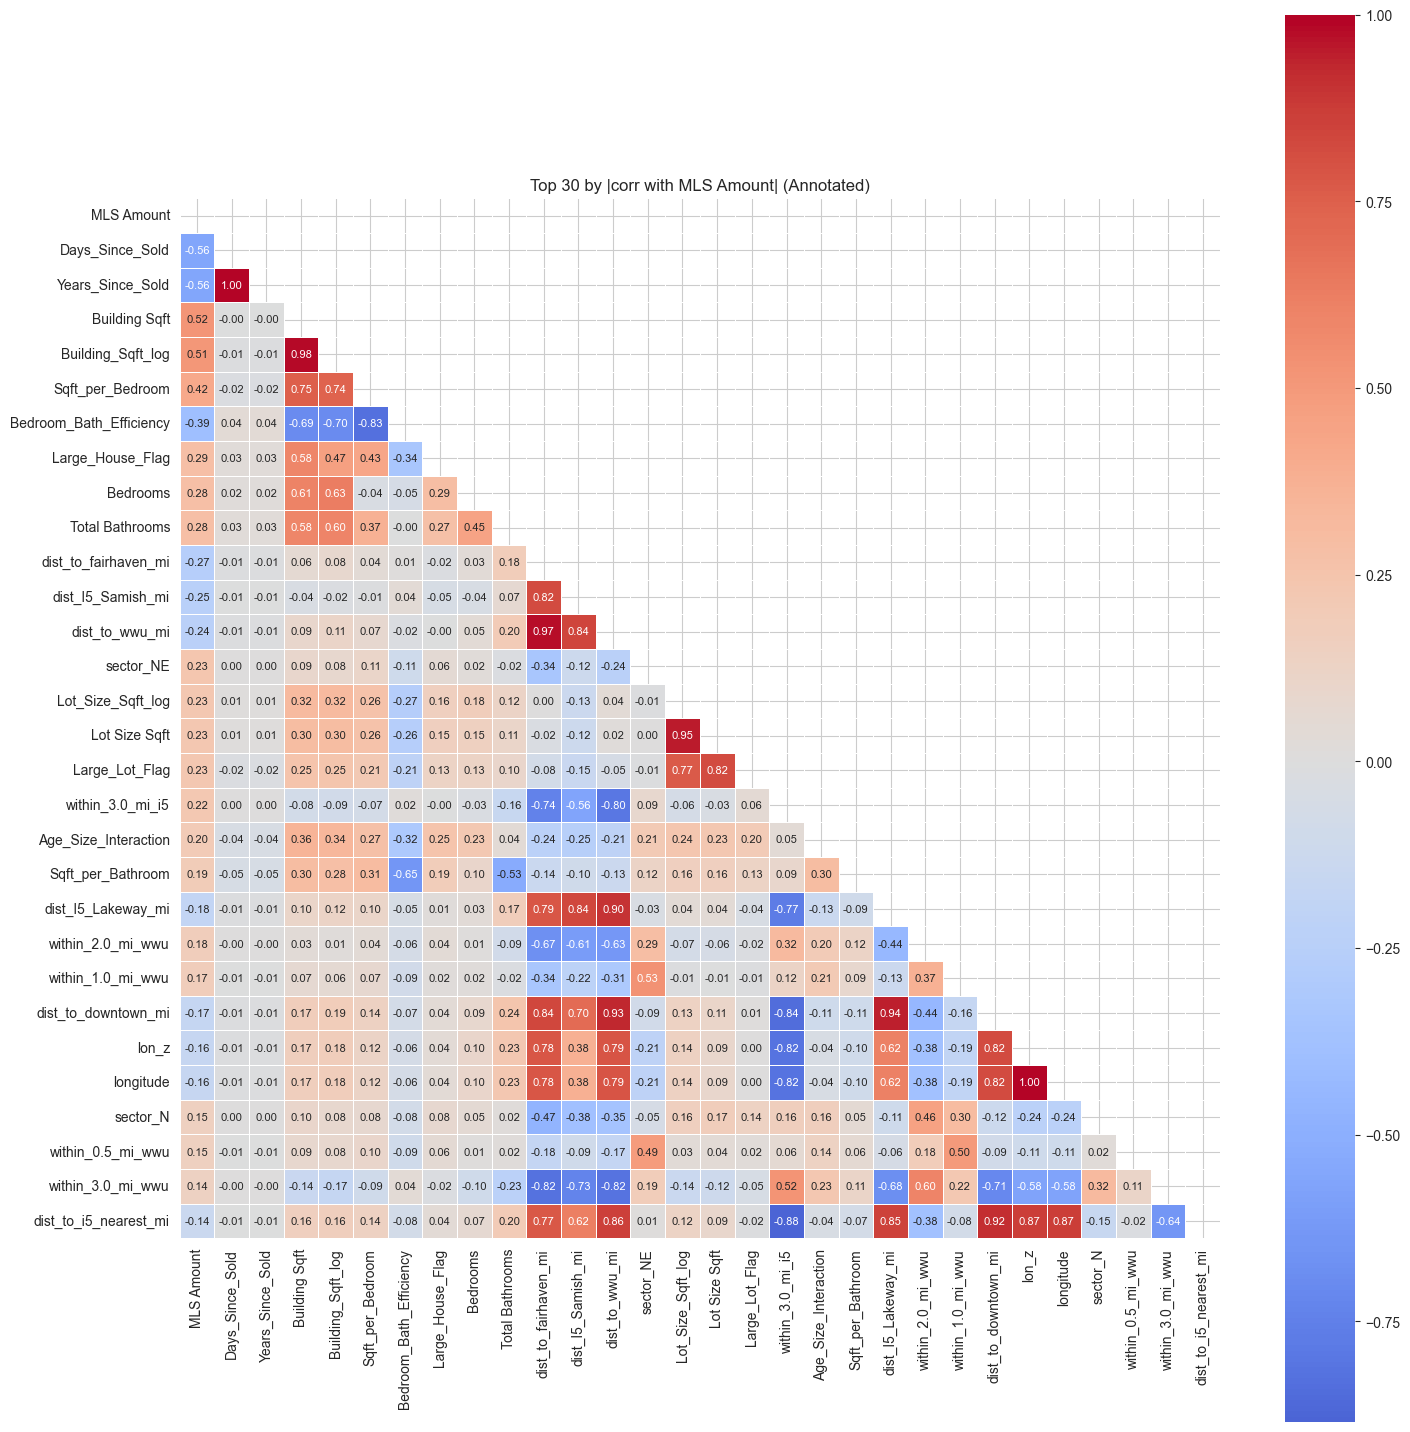


Top correlations with MLS Amount:
Days_Since_Sold           -0.555428
Years_Since_Sold          -0.555428
Building Sqft              0.517744
Building_Sqft_log          0.508647
Sqft_per_Bedroom           0.418051
Bedroom_Bath_Efficiency   -0.394217
Large_House_Flag           0.285509
Bedrooms                   0.280310
Total Bathrooms            0.278782
dist_to_fairhaven_mi      -0.266216
dist_I5_Samish_mi         -0.247808
dist_to_wwu_mi            -0.241573
sector_NE                  0.234721
Lot_Size_Sqft_log          0.234062
Lot Size Sqft              0.233079


In [23]:
# ==== Correlation Heatmap(s) for Feature-Engineered DataFrame (df_fe) ====

# 1) Select numeric features (treat bools as ints)
df_num = df_fe.select_dtypes(include=["number", "bool"]).copy()
for c in df_num.select_dtypes(include=["bool"]).columns:
    df_num[c] = df_num[c].astype(int)

# 2) Drop zero-variance cols (avoid NaNs in corr)
zero_var = df_num.columns[df_num.nunique(dropna=False) <= 1]
if len(zero_var):
    print("Dropping zero-variance columns from correlation:", zero_var.tolist())
    df_num = df_num.drop(columns=zero_var)

# 3) Compute Pearson correlation
corr = df_num.corr(method="pearson")

# 4) Order by absolute correlation with target (if present)
TARGET = "MLS Amount"
if TARGET in corr.columns:
    order = corr[TARGET].abs().sort_values(ascending=False).index.tolist()
    corr = corr.loc[order, order]

# 5A) FULL heatmap (no annotations; better for many features)
mask = np.triu(np.ones_like(corr, dtype=bool))
n_feats = corr.shape[0]
fig_w = min(22, max(10, n_feats * 0.25))  # scale width with #features (cap at 22")
fig_h = min(22, max(8,  n_feats * 0.25))  # scale height with #features (cap at 22")

plt.figure(figsize=(fig_w, fig_h))
sns.heatmap(
    corr,
    mask=mask,
    cmap="coolwarm",
    center=0,
    square=True,
    cbar=True,
    linewidths=0.4
)
plt.title("Correlation Heatmap — All Numeric Features (df_fe)")
plt.tight_layout()
plt.show()

# 5B) TOP-N heatmap with annotations (clearer labels)
TOP_N = 30
if TARGET in corr.columns:
    top_order = corr[TARGET].abs().sort_values(ascending=False).head(TOP_N).index.tolist()
    corr_top = corr.loc[top_order, top_order]
else:
    # if no target present, just take first TOP_N in current order
    corr_top = corr.iloc[:TOP_N, :TOP_N]

mask_top = np.triu(np.ones_like(corr_top, dtype=bool))
plt.figure(figsize=(min(22, max(10, corr_top.shape[0] * 0.5)),
                    min(22, max(8,  corr_top.shape[0] * 0.5))))
sns.heatmap(
    corr_top,
    mask=mask_top,
    cmap="coolwarm",
    center=0,
    square=True,
    cbar=True,
    linewidths=0.4,
    annot=True,
    fmt=".2f",
    annot_kws={"size": 8}
)
plt.title(f"Top {min(TOP_N, corr.shape[0])} by |corr with {TARGET}| (Annotated)")
plt.tight_layout()
plt.show()

# 6) Print top correlations with the target
if TARGET in corr.columns:
    print("\nTop correlations with MLS Amount:")
    print(
        corr[TARGET]
        .drop(TARGET)
        .sort_values(key=lambda s: s.abs(), ascending=False)
        .head(15)
        .to_string()
    )

## Feature Engineering — Summary & Signal Check

**What we added (high level).**
- **Scale & age:** `Property_Age`, `Days_Since_Sold`, `Years_Since_Sold`, log-transforms (`Building_Sqft_log`, `Lot_Size_Sqft_log`).
- **Efficiency ratios:** `Lot_Efficiency`, `Sqft_per_Bedroom`, `Sqft_per_Bathroom`, `Bedroom_Bath_Ratio`, `Luxury_Score`, `Bedroom_Bath_Efficiency`.
- **Flags & interactions:** `Large_Lot_Flag`, `Large_House_Flag`, `Premium_Property`, `Age_Size_Interaction`.
- **Geo proximity/trend:** distances to downtown/WWU/Fairhaven/airport/I-5/lake, nearest-I5, bearings & sector one-hots, `lat_z`, `lon_z`.
- **Seasonality:** month + season dummies.

**Top correlations with `MLS Amount` (|r| shown; sign in list):**
- Time recency: `Days_Since_Sold` **−0.56**, `Years_Since_Sold` **−0.56** → *newer sales priced higher (market appreciation)*
- Size: `Building Sqft` **+0.52**, `Building_Sqft_log` **+0.51** → *larger homes → higher prices; log smooths skew*
- Intensity/efficiency: `Sqft_per_Bedroom` **+0.42** → *more space per bedroom tracks premium*
- Density inverse: `Bedroom_Bath_Efficiency` **−0.39** → *more beds+baths per sqft (denser) lowers PPS*
- Premium flag: `Large_House_Flag` **+0.29**; beds/baths counts **≈ +0.28**
- Neighborhood access: `dist_to_fairhaven_mi` **−0.27**, `dist_I5_Samish_mi` **−0.25**, `dist_to_wwu_mi` **−0.24** → *closer to these areas → higher prices*
- Orientation: `sector_NE` **+0.23** (spatial gradient)
- Lot size (raw/log): **≈ +0.23** (weaker than building sqft)

**Takeaways.**
- **Time matters most** in this cut (strong negative correlation with “time since sold” → appreciation).
- **Livable size** (building sqft) dominates raw signal; **ratios** add useful nuance (space per bedroom).
- **Location signal** appears via distances and sectors; effects are meaningful though smaller than size/recency.

**Modeling notes.**
- Expect **multicollinearity** among size variables (sqft, beds, baths, ratios, flags). Prefer **regularized models** (Ridge/Lasso/Elastic Net) or tree ensembles.
- Consider **log-transforming target** or using `Building_Sqft_log` in linear models to reduce heteroskedasticity.
- Keep an eye on **leakage**: all features are derived from information available at listing time (safe).

# 5.0 Modeling Approach

## Overview
To rigorously evaluate predictive performance, I implemented and compared a suite of regression models, progressing from simple baselines to more advanced approaches. This staged framework demonstrates both the value of **feature engineering (FE)** and the comparative strengths of different algorithms.

---

## 1. Baseline Models (No Feature Engineering)
- **Linear Regression (no FE):**
  - A simple OLS regression using only the cleaned raw features.

- **XGBoost Regression (no FE):**
  - A boosted tree ensemble directly on raw features.

---

## 2. Models with Feature Engineering (FE)
- **Linear Regression (with FE):**
  - Incorporates engineered ratios, log transforms, temporal features, and geo signals.

- **XGBoost Regression (with FE):**
  - Boosted trees trained on the enriched feature set.

---

## 3. Regularized Linear Models (with FE)
To address **multicollinearity** and improve generalization, I applied:
- **Ridge Regression**
- **Lasso Regression**
- **Elastic Net Regression**

---

## 4. Random Forest (with FE + Randomized Search)
- **Random Forest (RS):**
  - Tuned using randomized search across candidate configurations.

---

## 5. Final Model: Optimized XGBoost (with FE)
- Conducted a **randomized hyperparameter search** with cross-validation on FE features.
- XGBoost was selected as the **final model** due to its balance of bias/variance, ability to capture nonlinearities, and superior performance.

---

## Model Comparison Table
(A detailed table of Train/Test R² and RMSE for all models is provided in the **Results** section below.)

In [24]:
# ==========================================
# Modeling Utilities: prep, train, evaluate
# ==========================================

# -----------------------------
# Data prep
# -----------------------------
def prepare_Xy(
    df: pd.DataFrame,
    target: str,
    drop_cols: Optional[List[str]] = None,
) -> Tuple[pd.DataFrame, pd.Series, List[str]]:
    """Return numeric X, y with NaNs dropped consistently."""
    drop_cols = (drop_cols or []) + [target]
    X = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")
    y = df[target].astype(float)

    X = X.apply(pd.to_numeric, errors="coerce").astype(float)
    mask = X.notna().all(axis=1) & y.notna()
    X, y = X.loc[mask], y.loc[mask]
    return X, y, X.columns.tolist()


def split(
    X: pd.DataFrame, y: pd.Series, test_size: float = 0.2, seed: int = 42
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    return train_test_split(X, y, test_size=test_size, random_state=seed)


# -----------------------------
# Diagnostics (1×5 compact row)
# -----------------------------
def plot_diagnostics_row(
    y_true: pd.Series,
    y_pred: np.ndarray,
    model,
    feature_names: List[str],
    title_suffix: str = "",
    max_bars: int = 10,
):
    residuals = y_true - y_pred
    fig, axes = plt.subplots(1, 5, figsize=(18, 3.6))
    ax1, ax2, ax3, ax4, ax5 = axes

    # A) Predicted vs Actual
    ax1.scatter(y_true, y_pred, s=8)
    lo, hi = float(min(y_true.min(), y_pred.min())), float(max(y_true.max(), y_pred.max()))
    ax1.plot([lo, hi], [lo, hi])
    ax1.set_title(f"Predicted vs Actual{title_suffix}", fontsize=10)
    ax1.set_xlabel("Actual", fontsize=9)
    ax1.set_ylabel("Predicted", fontsize=9)

    # B) Residuals vs Fitted
    ax2.scatter(y_pred, residuals, s=8)
    ax2.axhline(0)
    ax2.set_title("Residuals vs Fitted", fontsize=10)
    ax2.set_xlabel("Fitted", fontsize=9)
    ax2.set_ylabel("Residual", fontsize=9)

    # C) Residuals Histogram
    ax3.hist(residuals, bins=40)
    ax3.set_title("Residuals Histogram", fontsize=10)
    ax3.set_xlabel("Residual", fontsize=9)
    ax3.set_ylabel("Freq", fontsize=9)

    # D) Q–Q plot
    try:
        from scipy import stats
        (osm, osr), (slope, intercept, r) = stats.probplot(residuals, dist="norm")
        ax4.scatter(osm, osr, s=6)
        ax4.plot(osm, slope*osm + intercept)
        ax4.set_title("Q–Q Plot", fontsize=10)
        ax4.set_xlabel("Theoretical Quantiles", fontsize=9)
        ax4.set_ylabel("Ordered Residuals", fontsize=9)
    except Exception:
        ax4.axis("off")
        ax4.text(0.5, 0.5, "SciPy not available\n(skipped Q–Q plot)", ha="center", va="center", fontsize=9)

    # E) Coefs/Importances
    imp = None
    label = ""
    if hasattr(model, "coef_") and getattr(model, "coef_", None) is not None:
        coef = np.ravel(model.coef_)
        imp = pd.DataFrame({"feature": feature_names, "val": coef})
        label = "Coef"
    elif hasattr(model, "feature_importances_"):
        fi = np.ravel(model.feature_importances_)
        imp = pd.DataFrame({"feature": feature_names, "val": fi})
        label = "Importance"
    elif isinstance(model, Pipeline):
        last = list(model.named_steps.values())[-1]
        if hasattr(last, "coef_") and getattr(last, "coef_", None) is not None:
            coef = np.ravel(last.coef_)
            imp = pd.DataFrame({"feature": feature_names, "val": coef})
            label = "Coef"
        elif hasattr(last, "feature_importances_"):
            fi = np.ravel(last.feature_importances_)
            imp = pd.DataFrame({"feature": feature_names, "val": fi})
            label = "Importance"

    if isinstance(imp, pd.DataFrame):
        imp = imp.assign(abs_val=lambda d: d["val"].abs()).sort_values("abs_val", ascending=False).head(max_bars)
        imp = imp.iloc[::-1]
        ax5.barh(imp["feature"], imp["val"])
        ax5.set_title(f"Top {label}s", fontsize=10)
        ax5.set_xlabel(label, fontsize=9)
        ax5.tick_params(axis="y", labelsize=8)
    else:
        ax5.axis("off")
        ax5.text(0.5, 0.5, "No coef/importance available", ha="center", va="center", fontsize=9)

    plt.tight_layout(w_pad=1.2)
    plt.show()


# -----------------------------
# MAE / MAPE helpers
# -----------------------------
def mae_mape(y_true: np.ndarray, y_pred: np.ndarray, eps: float = 1e-8) -> Tuple[float, float]:
    """
    Returns (MAE, MAPE%). MAPE guards division-by-zero by dividing by max(|y|, eps).
    """
    mae = float(mean_absolute_error(y_true, y_pred))
    denom = np.maximum(np.abs(np.asarray(y_true, dtype=float)), eps)
    mape = float(np.mean(np.abs((np.asarray(y_true) - np.asarray(y_pred)) / denom)) * 100.0)
    return mae, mape


# -----------------------------
# Fit + evaluate one model
# -----------------------------
def fit_and_eval(
    name: str,
    estimator,
    df: pd.DataFrame,
    target: str,
    drop_cols: Optional[List[str]] = None,
    test_size: float = 0.2,
    seed: int = 42,
    do_plots: bool = True,
    return_estimator: bool = False,
):
    X, y, feat_names = prepare_Xy(df, target, drop_cols=drop_cols)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)

    rmse = float(np.sqrt(mean_squared_error(y_test, y_pred)))
    r2_tr = float(estimator.score(X_train, y_train))
    r2_te = float(r2_score(y_test, y_pred))
    mae, mape = mae_mape(y_test, y_pred)

    print(f"{name}\n" + "-"*len(name))
    print(f"Train R²: {r2_tr:.3f} | Test R²: {r2_te:.3f} | "
          f"RMSE: {rmse:,.0f} | MAE: {mae:,.0f} | MAPE: {mape:.2f}%")

    if do_plots:
        plot_diagnostics_row(y_test, y_pred, estimator, feat_names, title_suffix=f" — {name}")

    metrics = {
        "Model": name,
        "Train R²": r2_tr,
        "Test R²": r2_te,
        "Test RMSE": rmse,
        "Test MAE": mae,
        "Test MAPE (%)": mape,
    }
    return (metrics, estimator) if return_estimator else metrics


def run_experiments(
    df: pd.DataFrame,
    target: str,
    drop_cols: Optional[List[str]],
    model_registry: Dict[str, Callable[[], object]],
    test_size: float = 0.2,
    seed: int = 42,
    do_plots: bool = True,
    label: Optional[str] = None,
    return_estimators: bool = False,
):
    results = []
    trained = {}

    for name, ctor in model_registry.items():
        est = ctor()
        disp_name = name if not label else f"{name} ({label})"
        if return_estimators:
            metrics, fitted = fit_and_eval(
                disp_name, est, df, target, drop_cols,
                test_size=test_size, seed=seed, do_plots=do_plots, return_estimator=True
            )
            trained[disp_name] = fitted
            results.append(metrics)
        else:
            metrics = fit_and_eval(
                disp_name, est, df, target, drop_cols,
                test_size=test_size, seed=seed, do_plots=do_plots, return_estimator=False
            )
            results.append(metrics)

    cols = ["Model", "Train R²", "Test R²", "Test RMSE", "Test MAE", "Test MAPE (%)"]
    dfres = pd.DataFrame(results, columns=cols)
    return (dfres, trained) if return_estimators else dfres

Linear (Raw)
------------
Train R²: 0.357 | Test R²: 0.353 | RMSE: 164,450 | MAE: 132,909 | MAPE: 30.64%


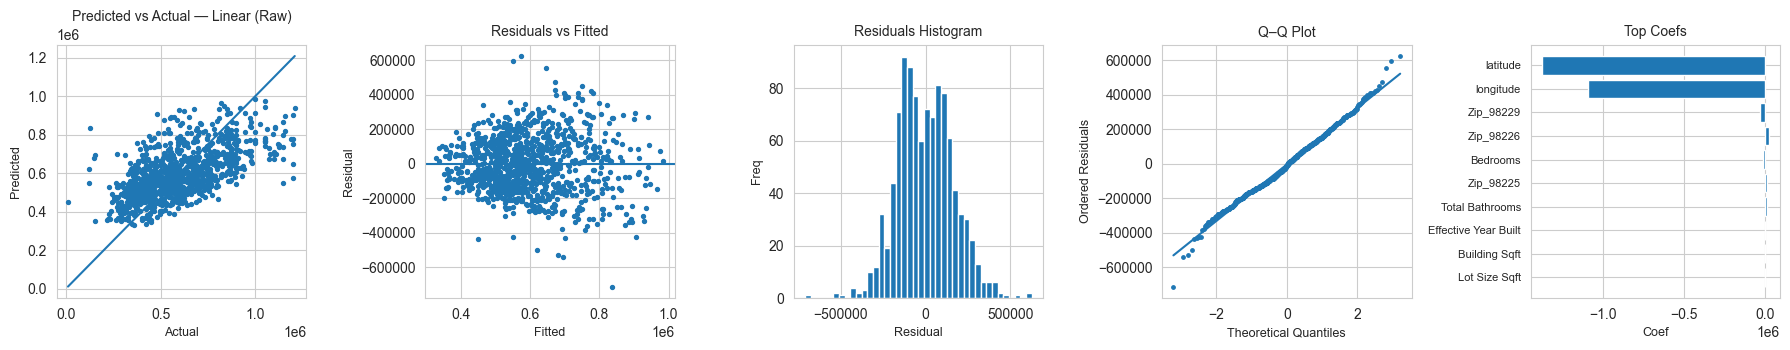

XGBoost (Raw)
-------------
Train R²: 0.879 | Test R²: 0.422 | RMSE: 155,449 | MAE: 125,596 | MAPE: 27.22%


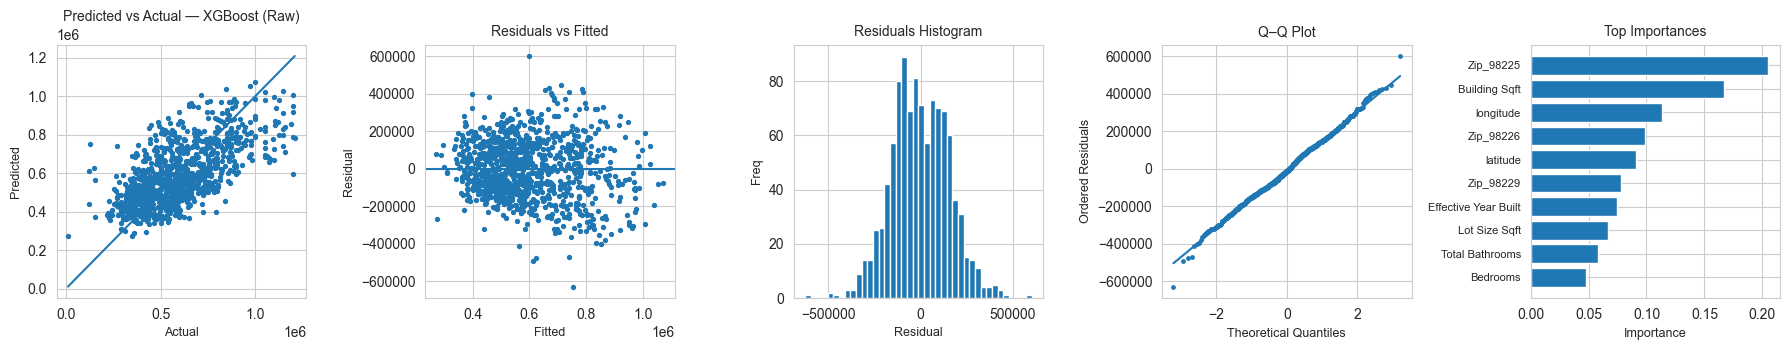

,Model,Train R²,Test R²,Test RMSE,Test MAE,Test MAPE (%)
0,Linear (Raw),0.356513,0.353084,164449.969977,132908.933369,30.641841
1,XGBoost (Raw),0.878528,0.421965,155448.609466,125595.537464,27.224336


In [25]:
drop_cols_common = ["Address", "MLS Date"]

models_raw = {
    "Linear": lambda: LinearRegression(),
    "XGBoost": lambda: xgb.XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        tree_method="hist",
        eval_metric="rmse",
    ),
}

results_raw = run_experiments(
    df=df_cleaned, target="MLS Amount",
    drop_cols=drop_cols_common, model_registry=models_raw,
    label="Raw"
)
results_raw

Linear (FE)
-----------
Train R²: 0.731 | Test R²: 0.758 | RMSE: 100,496 | MAE: 73,922 | MAPE: 17.18%


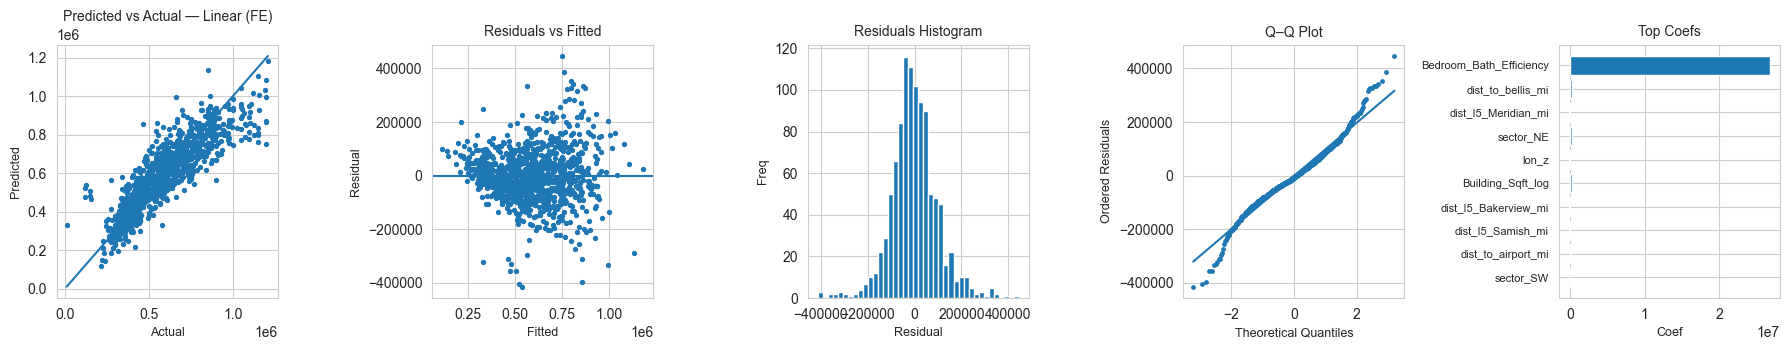

RidgeCV (FE)
------------
Train R²: 0.725 | Test R²: 0.753 | RMSE: 101,691 | MAE: 74,908 | MAPE: 17.45%


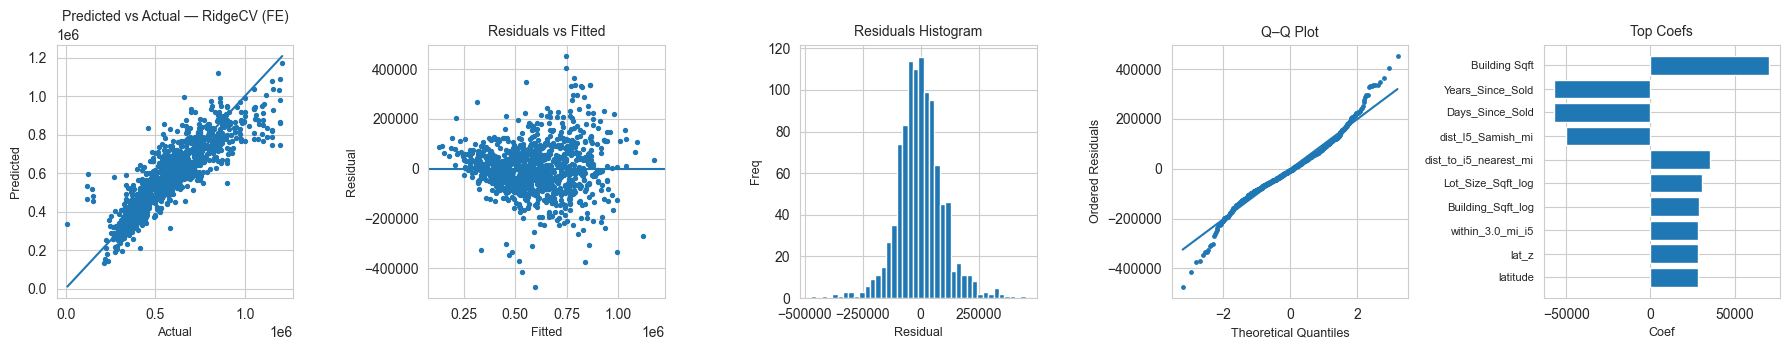

LassoCV (FE)
------------
Train R²: 0.730 | Test R²: 0.757 | RMSE: 100,820 | MAE: 74,086 | MAPE: 17.23%


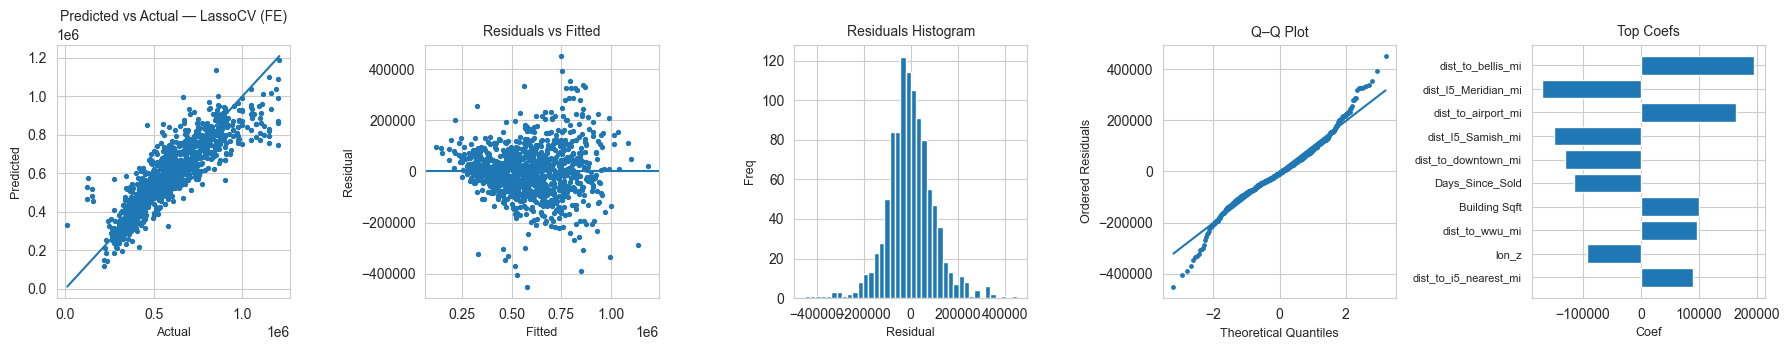

ElasticNetCV (FE)
-----------------
Train R²: 0.730 | Test R²: 0.757 | RMSE: 100,820 | MAE: 74,086 | MAPE: 17.23%


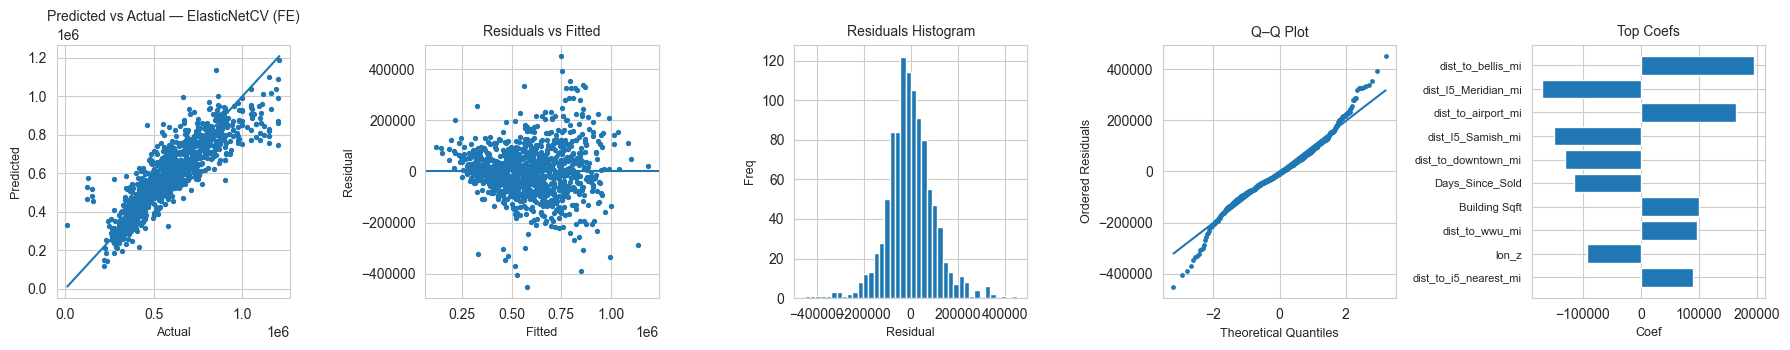

RandomForest (FE)
-----------------
Train R²: 0.943 | Test R²: 0.803 | RMSE: 90,729 | MAE: 64,305 | MAPE: 15.56%


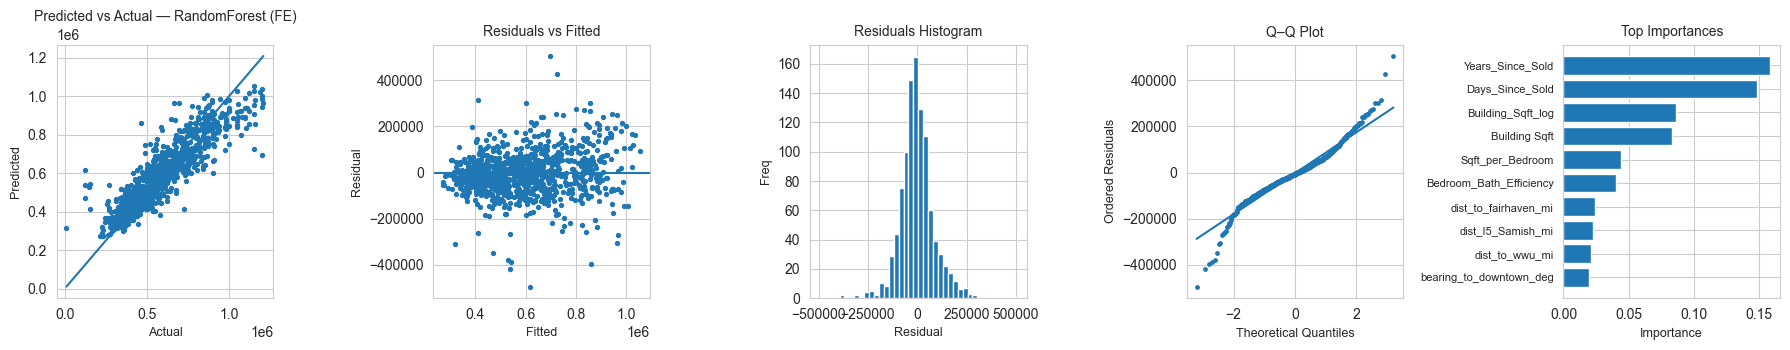

XGBoost (FE)
------------
Train R²: 0.999 | Test R²: 0.835 | RMSE: 82,952 | MAE: 58,231 | MAPE: 13.87%


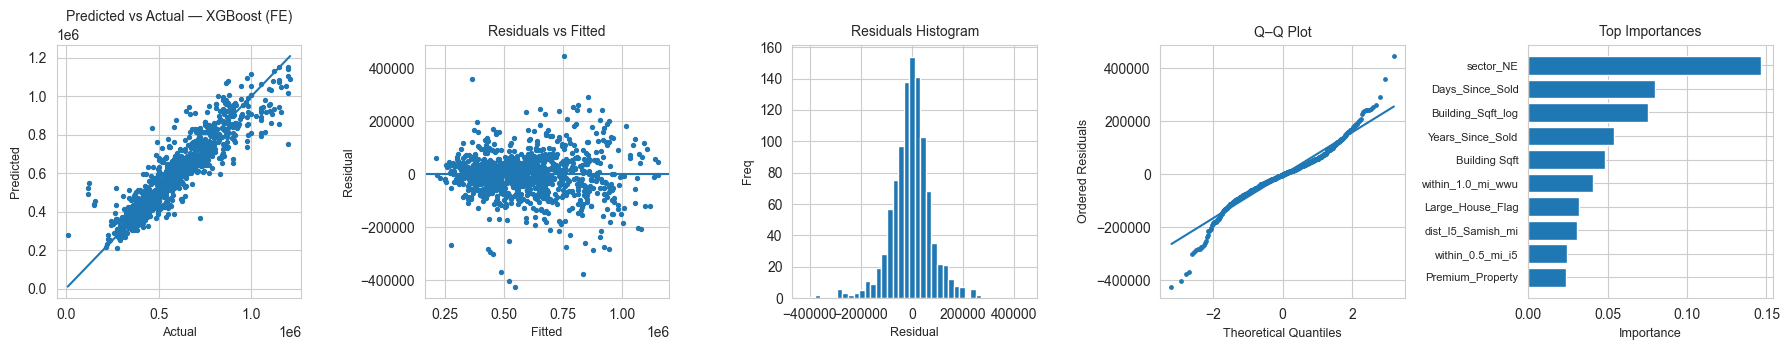

,Model,Train R²,Test R²,Test RMSE,Test MAE,Test MAPE (%)
0,Linear (FE),0.730771,0.758408,100496.442418,73921.685942,17.179719
1,RidgeCV (FE),0.724955,0.752630,101691.173795,74907.885798,17.453456
2,LassoCV (FE),0.729526,0.756849,100820.212392,74086.230453,17.232960
3,ElasticNetCV (FE),0.729526,0.756849,100820.212392,74086.230453,17.232960
4,RandomForest (FE),0.943174,0.803087,90729.118870,64304.580446,15.560807
5,XGBoost (FE),0.998745,0.835398,82951.979296,58231.064751,13.872958


In [26]:
models_fe = {
    "Linear": lambda: LinearRegression(),
    "RidgeCV": lambda: Pipeline([("scaler", StandardScaler()), ("ridge", RidgeCV(alphas=np.logspace(-3,3,21), cv=5))]),
    "LassoCV": lambda: Pipeline([("scaler", StandardScaler()), ("lasso", LassoCV(alphas=np.logspace(-3,3,21), cv=5, max_iter=2000))]),
    "ElasticNetCV": lambda: Pipeline([("scaler", StandardScaler()), ("enet", ElasticNetCV(l1_ratio=[.2,.5,.8,.9,.95,1.0], alphas=np.logspace(-3,3,21), cv=5, max_iter=2000))]),
    "RandomForest": lambda: RandomForestRegressor(
        n_estimators=500, max_depth=None, min_samples_split=4, min_samples_leaf=2,
        max_features="sqrt", n_jobs=-1, random_state=42
    ),
    "XGBoost": lambda: xgb.XGBRegressor(
        n_estimators=2000, learning_rate=0.03, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
        random_state=42, n_jobs=-1, tree_method="hist", eval_metric="rmse"
    ),
}

results_fe = run_experiments(
    df=df_fe, target="MLS Amount",
    drop_cols=drop_cols_common, model_registry=models_fe,
    label="FE"
)
results_fe

In [27]:
results_all = pd.concat([results_raw, results_fe], ignore_index=True)
results_all = results_all.sort_values(["Test RMSE", "Model"])
print("\nModel Comparison:")
print(results_all.to_string(index=False))


Model Comparison:
            Model  Train R²  Test R²     Test RMSE      Test MAE  Test MAPE (%)
     XGBoost (FE)  0.998745 0.835398  82951.979296  58231.064751      13.872958
RandomForest (FE)  0.943174 0.803087  90729.118870  64304.580446      15.560807
      Linear (FE)  0.730771 0.758408 100496.442418  73921.685942      17.179719
ElasticNetCV (FE)  0.729526 0.756849 100820.212392  74086.230453      17.232960
     LassoCV (FE)  0.729526 0.756849 100820.212392  74086.230453      17.232960
     RidgeCV (FE)  0.724955 0.752630 101691.173795  74907.885798      17.453456
    XGBoost (Raw)  0.878528 0.421965 155448.609466 125595.537464      27.224336
     Linear (Raw)  0.356513 0.353084 164449.969977 132908.933369      30.641841


In [28]:
# --- helpers ---


def mae_mape(y_true, y_pred, eps: float = 1e-8):
    mae = float(mean_absolute_error(y_true, y_pred))
    denom = np.maximum(np.abs(np.asarray(y_true, dtype=float)), eps)
    mape = float(np.mean(np.abs((np.asarray(y_true) - np.asarray(y_pred)) / denom)) * 100.0)
    return mae, mape

# ==== One-shot XGBoost RandSearch workflow (with MAE/MAPE in results) ====
def xgb_randsearch_workflow(
    df: pd.DataFrame,
    target: str = "MLS Amount",
    drop_cols: Optional[List[str]] = None,
    test_size: float = 0.20,
    seed: int = 42,
    n_iter: int = 5,
    cv_splits: int = 5,
    plot_params: bool = True,
) -> Tuple[RandomizedSearchCV, xgb.XGBRegressor, pd.DataFrame]:
    drop_cols = drop_cols or []

    # --- Prep & split ---
    X, y, feat_names = prepare_Xy(df, target, drop_cols=drop_cols)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

    # --- RS config ---
    base = xgb.XGBRegressor(objective="reg:squarederror", random_state=seed,
                            n_jobs=-1, tree_method="hist", eval_metric="rmse")
    param_dist = {
        "n_estimators":     randint(200, 3001),
        "max_depth":        randint(2, 16),
        "min_child_weight": randint(1, 11),
        "subsample":        uniform(0.5, 0.5),
        "colsample_bytree": uniform(0.3, 0.7),
        "learning_rate":    loguniform(1e-3, 3e-1),
        "reg_lambda":       loguniform(1e-3, 1e2),
        "reg_alpha":        loguniform(1e-5, 1e1),
    }
    cv = KFold(n_splits=cv_splits, shuffle=True, random_state=seed)
    rs = RandomizedSearchCV(
        estimator=base,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring="neg_root_mean_squared_error",
        cv=cv,
        n_jobs=-1,
        random_state=seed,
        refit=True,
        verbose=0,
    )

    # --- Fit on train; evaluate best on hold-out ---
    rs.fit(X_train, y_train)
    best_xgb: xgb.XGBRegressor = rs.best_estimator_

    y_pred = best_xgb.predict(X_test)
    rmse  = float(np.sqrt(mean_squared_error(y_test, y_pred)))
    r2_tr = float(best_xgb.score(X_train, y_train))
    r2_te = float(r2_score(y_test, y_pred))
    mae, mape = mae_mape(y_test, y_pred)

    print("XGBoost (FE) — RandomizedSearchCV (one-shot)")
    print("============================================")
    print("Best params:")
    for k, v in rs.best_params_.items():
        print(f"  {k}: {v}")
    print(f"\nBest CV RMSE (mean CV): {-rs.best_score_:,.0f}")
    print(f"Train R^2: {r2_tr:.3f} | Test R^2: {r2_te:.3f} | RMSE: {rmse:,.0f} | MAE: {mae:,.0f} | MAPE: {mape:.2f}%")

    # --- Plots ---
    plot_diagnostics_row(y_test, y_pred, best_xgb, feat_names,
                         title_suffix=" — XGBoost (FE) — RandSearch (best)")

    importances = best_xgb.feature_importances_
    imp_df = (pd.DataFrame({"feature": feat_names, "importance": importances})
                .sort_values("importance", ascending=True).tail(10))
    plt.figure(figsize=(7,4))
    plt.barh(imp_df["feature"], imp_df["importance"])
    plt.title("XGBoost (best) — Top Feature Importances")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

    if plot_params:
        cvres = pd.DataFrame(rs.cv_results_).copy()
        cvres["rmse"] = -cvres["mean_test_score"]
        params = ["n_estimators","learning_rate","max_depth",
                  "subsample","colsample_bytree","min_child_weight",
                  "reg_lambda","reg_alpha"]
        n = len(params); cols = 4; rows = int(np.ceil(n/cols))
        plt.figure(figsize=(4*cols, 3.2*rows))
        for i, p in enumerate(params, 1):
            ax = plt.subplot(rows, cols, i)
            ax.scatter(cvres[f"param_{p}"], cvres["rmse"], s=35, alpha=0.8)
            ax.set_xlabel(p); ax.set_ylabel("CV RMSE"); ax.set_title(p)
        plt.suptitle("XGB RandSearch — Hyperparameters vs CV RMSE", y=1.02)
        plt.tight_layout()
        plt.show()

    # --- Append to results_all with MAE/MAPE too ---
    row = pd.DataFrame([{
        "Model": f"XGBoost (FE) — RandSearch (best, n_iter={n_iter}, cv={cv_splits})",
        "Train R²": r2_tr,
        "Test R²":  r2_te,
        "Test RMSE": rmse,
        "Test MAE": mae,
        "Test MAPE (%)": mape,
    }])

    cols = ["Model", "Train R²", "Test R²", "Test RMSE", "Test MAE", "Test MAPE (%)"]
    try:
        globals()["results_all"] = results_all.reindex(columns=cols)
        globals()["results_all"] = pd.concat([results_all, row], ignore_index=True)
    except NameError:
        globals()["results_all"] = row.reindex(columns=cols)

    globals()["results_all"] = results_all.sort_values(["Test RMSE", "Model"]).reset_index(drop=True)
    print("\nUpdated Model Comparison:")
    print(results_all.to_string(index=False))

    return rs, best_xgb, imp_df

XGBoost (FE) — RandomizedSearchCV (one-shot)
Best params:
  colsample_bytree: 0.3116114802494993
  learning_rate: 0.018557377359658574
  max_depth: 4
  min_child_weight: 4
  n_estimators: 1934
  reg_alpha: 0.0001112240164611299
  reg_lambda: 2.8489753426125652
  subsample: 0.6933676731502687

Best CV RMSE (mean CV): 90,272
Train R^2: 0.938 | Test R^2: 0.845 | RMSE: 80,396 | MAE: 56,243 | MAPE: 13.25%


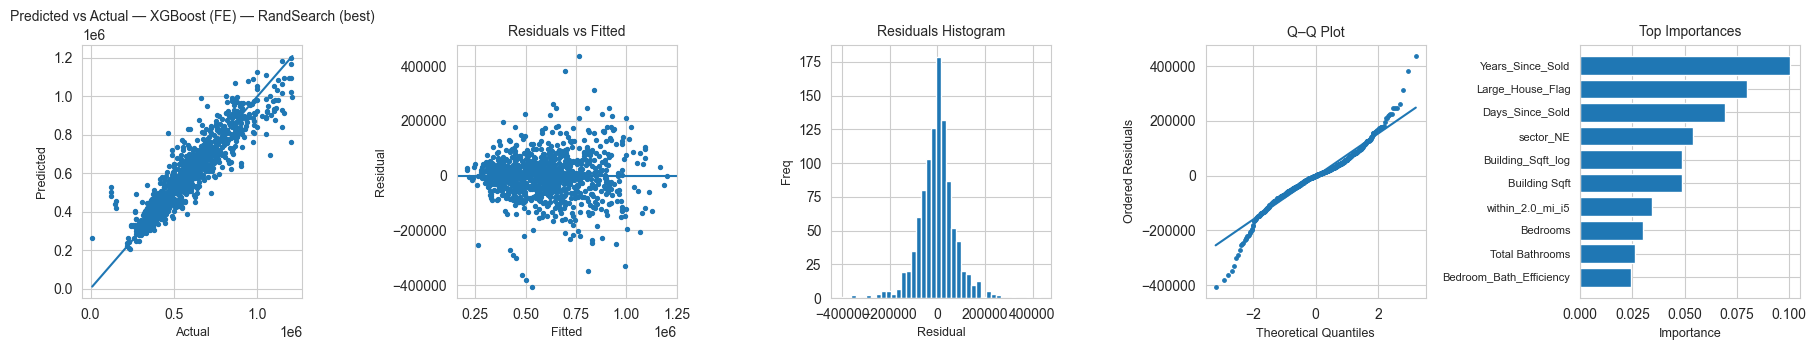

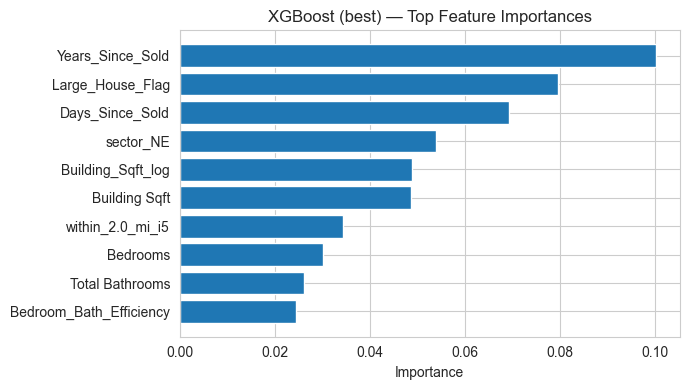

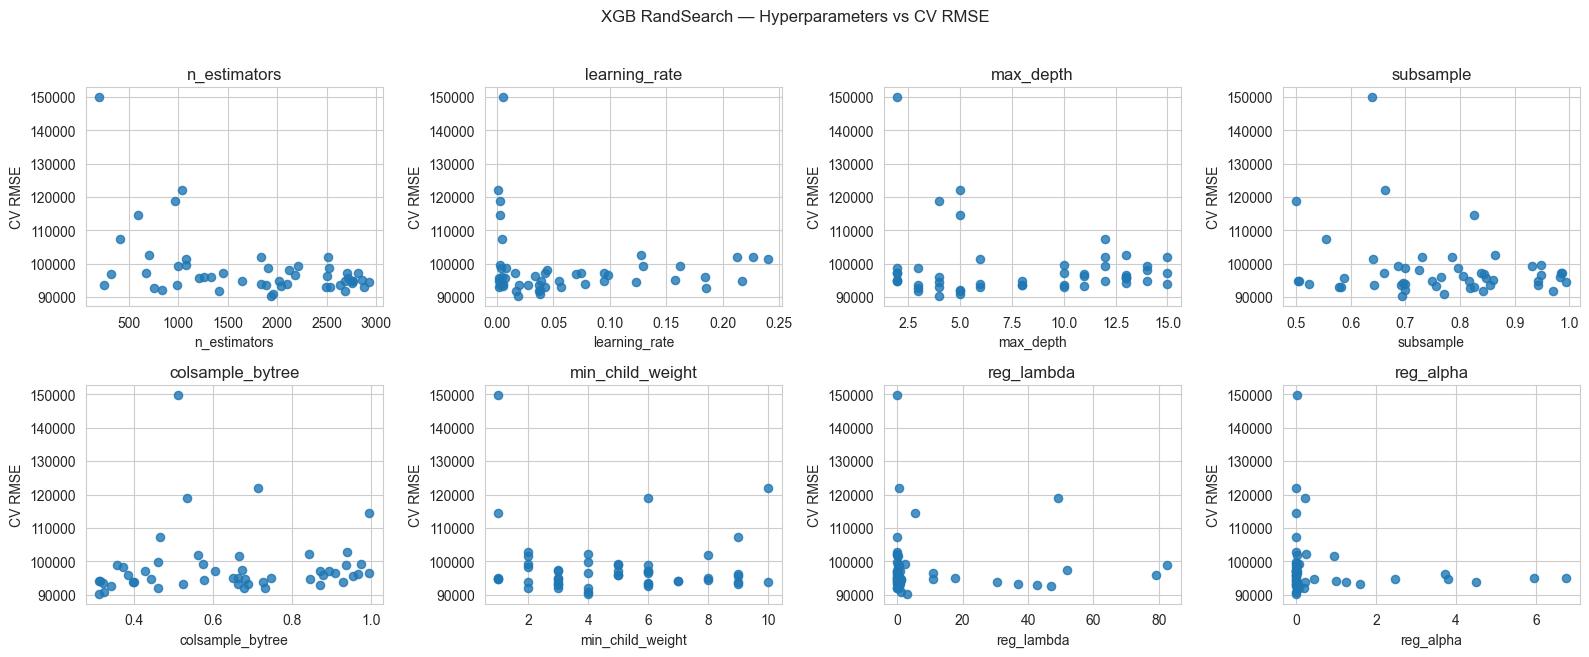


Updated Model Comparison:
                                            Model  Train R²  Test R²     Test RMSE      Test MAE  Test MAPE (%)
XGBoost (FE) — RandSearch (best, n_iter=50, cv=5)  0.937532 0.845385  80396.169423  56243.385942      13.245796
XGBoost (FE) — RandSearch (best, n_iter=50, cv=5)  0.937532 0.845385  80396.169423  56243.385942      13.245796
                                     XGBoost (FE)  0.998745 0.835398  82951.979296  58231.064751      13.872958
                                RandomForest (FE)  0.943174 0.803087  90729.118870  64304.580446      15.560807
                                      Linear (FE)  0.730771 0.758408 100496.442418  73921.685942      17.179719
                                ElasticNetCV (FE)  0.729526 0.756849 100820.212392  74086.230453      17.232960
                                     LassoCV (FE)  0.729526 0.756849 100820.212392  74086.230453      17.232960
                                     RidgeCV (FE)  0.724955 0.752630 101691.1

In [38]:
rs, best_xgb, top_imp = xgb_randsearch_workflow(
    df=df_fe,
    target="MLS Amount",
    drop_cols=["Address", "MLS Date"],
    test_size=0.20,
    seed=42,
    n_iter=50,
    cv_splits=5,
    plot_params=True,
)

# Results and Analysis

## Updated Model Performance Summary
After extending the randomized search to **50 iterations with 5-fold CV**, the tuned XGBoost achieved the best balance of generalization and stability.

| Model                                       | Train R² | Test R² |  Test RMSE |  Test MAE | Test MAPE (%) |
|---------------------------------------------|---------:|--------:|-----------:|----------:|--------------:|
| **XGBoost (FE) — RandSearch (best, n_iter=50, cv=5)** | 0.938    | **0.845** | **80,396** | **56,243** | **13.25** |
| XGBoost (FE)                                | 0.999    | 0.835   | 82,952     | 58,231    | 13.87         |
| RandomForest (FE)                           | 0.943    | 0.803   | 90,729     | 64,305    | 15.56         |
| Linear Regression (FE)                      | 0.731    | 0.758   | 100,496    | 73,922    | 17.18         |
| ElasticNetCV (FE)                           | 0.730    | 0.757   | 100,820    | 74,086    | 17.23         |
| LassoCV (FE)                                | 0.730    | 0.757   | 100,820    | 74,086    | 17.23         |
| RidgeCV (FE)                                | 0.725    | 0.753   | 101,691    | 74,908    | 17.45         |
| XGBoost (Raw features only)                 | 0.879    | 0.422   | 155,449    | 125,596   | 27.22         |
| Linear Regression (Raw features only)       | 0.357    | 0.353   | 164,450    | 132,909   | 30.64         |

---

## Key Insights
- The **tuned XGBoost (RandSearch)** outperformed the baseline untuned version, improving Test R² from 0.835 → **0.845** and lowering RMSE by 2,500.
- Regularization from tuning reduced overfitting: Train R² dropped from 0.999 → 0.938 while Test R² improved, showing better generalization.
- **MAE (~\$56k)** and **MAPE (~13%)** for tuned XGBoost provide a more interpretable measure: on average, predictions were off by $56k, or 13% of the sale price.
- Random Forest remained competitive but with ~10k higher RMSE and worse MAPE.
- Linear and regularized linear models underperformed, unable to capture nonlinear relationships.
- Raw features (no FE) performed worst, reinforcing the importance of **feature engineering**.

---

## Diagnostic Visualizations
### Feature Importance (XGBoost tuned, n_iter=50)
The tuned XGBoost model highlighted the following **top drivers of housing prices**:

1. **Years_Since_Sold** – Strong negative signal, newer sales better predictors.
2. **Large_House_Flag** – Captures nonlinear size threshold effects.
3. **Days_Since_Sold** – Temporal recency boosts predictive power.
4. **Building Sqft (raw & log)** – Size remains fundamental in value.
5. **Bathrooms & Bedrooms** – Still key, but less predictive once ratios/logs included.
6. **Location features** (sector_NE, distance to I-5) – confirm spatial dynamics.

---

## Evaluation Metrics
- **R²:** Explained variance — shows tuned XGBoost explains ~84.5% of housing price variance.
- **RMSE:** ≈ **\$80k** error, lower than baseline (~\$165k raw linear regression).
- **MAE:** ≈ **\$56k** average error in absolute dollar terms.
- **MAPE:** ≈ **13%** relative error, meaning the model’s predictions are typically within ~13% of true prices.
- **Train vs Test R² gap:** small, indicating strong generalization.


---

## Conclusion
The **tuned XGBoost (RandSearch, n_iter=50)** is the **best-performing model**, achieving **Test R² = 0.845**, **RMSE ≈ \$80k**, **MAE ≈ \$56k**, and **MAPE ≈ 13%**.
This confirms that **feature engineering + careful hyperparameter tuning** delivers the strongest results for Bellingham housing price prediction.

# 7.0 Discussion and Conclusion

## Key Learnings and Takeaways
- **Feature Engineering is Essential:** Raw models on untransformed MLS data achieved poor accuracy (Test R² < 0.45). With domain-driven features such as log-scaled square footage, bedroom–bathroom efficiency ratios, and spatial distance measures, predictive power nearly doubled. This demonstrates the value of domain knowledge in model design.
- **Hyperparameter Tuning Improves Generalization:** Untuned XGBoost models nearly memorized the training set (Train R² ≈ 0.999) but generalized worse. After randomized search, Train R² dropped to ~0.94 while Test R² improved — showing that regularization and balanced parameter selection reduce overfitting.
- **Nonlinear Models Outperform Linear Ones:** Ridge, Lasso, and Elastic Net plateaued around Test R² ≈ 0.75, while tree-based methods (XGBoost, Random Forest) captured nonlinearities and feature interactions crucial in housing price prediction.

---

## What Did Not Work Well
- **Linear Models (Even Regularized):** Despite scaling and regularization, linear models could not capture complex nonlinear interactions. Test RMSE remained above 100k, making them unsuitable beyond a baseline benchmark.
- **Raw Features Alone:** Using raw MLS fields without transformation produced very high error (RMSE ≈ 155k) and unstable generalization. This underscores that raw housing data lacks predictive structure without preprocessing.

---

## Future work could include:
- **Similarity search** to optimze comparable property knowledge.
- **Stacking/ensembling** for marginal gains.
- Adding **temporal rolling features** to better capture market trends.

---

## Final Conclusion
The project demonstrates that **feature engineering + tuned gradient boosting** is the most effective pipeline for Bellingham housing price prediction. The optimized XGBoost achieved **Test R² = 0.845** and **RMSE ≈ $80k**, outperforming all alternatives.

While linear models provide interpretability, their predictive power is limited in this nonlinear domain. Future iterations will focus on **spatial validation, temporal features, and ensembling** to enhance robustness. Overall, the study highlights the critical role of **domain-informed feature engineering** combined with **modern ensemble methods** in real estate predictive modeling.

In [35]:
# ==== Time-based split: test = last N years by date_col (e.g., "MLS Date") ====
def time_based_split(
    df: pd.DataFrame,
    target: str,
    date_col: str = "MLS Date",
    drop_cols: Optional[List[str]] = None,
    test_years: int = 2,
    anchor: Optional[pd.Timestamp] = None,
):
    """
    Returns X_train, X_test, y_train, y_test using a cutoff date.
    cutoff = (anchor or df[date_col].max()) - test_years
    Test set = rows with date_col >= cutoff; Train = rows with date_col < cutoff.
    """
    drop_cols = (drop_cols or []) + [target]
    # 1) ensure datetime
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")

    # 2) pick cutoff
    max_date = df[date_col].max() if anchor is None else pd.to_datetime(anchor)
    cutoff = max_date - pd.DateOffset(years=test_years)

    # 3) split by time
    df_train = df[df[date_col] < cutoff].copy()
    df_test  = df[df[date_col] >= cutoff].copy()

    # 4) build X/y separately (no info bleed)
    def _prep(d):
        X = d.drop(columns=[c for c in drop_cols if c in d.columns], errors="ignore")
        y = d[target].astype(float)
        X = X.apply(pd.to_numeric, errors="coerce").astype(float)
        mask = X.notna().all(axis=1) & y.notna()
        return X.loc[mask], y.loc[mask]

    X_train, y_train = _prep(df_train)
    X_test,  y_test  = _prep(df_test)

    print(f"Time split with cutoff = {cutoff.date()}  (max date in data = {max_date.date()})")
    print(f"Train: {len(X_train):,} rows   Test (last {test_years}y): {len(X_test):,} rows")

    return X_train, X_test, y_train, y_test


def fit_and_eval_timebased(
    name: str,
    estimator,
    df: pd.DataFrame,
    target: str,
    date_col: str = "MLS Date",
    drop_cols: Optional[List[str]] = None,
    test_years: int = 2,
    do_plots: bool = True,
):
    X_train, X_test, y_train, y_test = time_based_split(
        df=df, target=target, date_col=date_col, drop_cols=drop_cols, test_years=test_years
    )
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    rmse = float(np.sqrt(mean_squared_error(y_test, y_pred)))
    r2_tr = float(estimator.score(X_train, y_train))
    r2_te = float(r2_score(y_test, y_pred))
    mae, mape = mae_mape(y_test, y_pred)
    print(f"{name}\n" + "-"*len(name))
    print(f"Train R²: {r2_tr:.3f} | Test R²: {r2_te:.3f} | RMSE: {rmse:,.0f} | MAE: {mae:,.0f} | MAPE: {mape:.2f}%")
    if do_plots:
        plot_diagnostics_row(y_test, y_pred, estimator, X_train.columns.tolist(),
                             title_suffix=f" — {name} (time-based)")
    return {"Model": name, "Train R²": r2_tr, "Test R²": r2_te,
            "Test RMSE": rmse, "Test MAE": mae, "Test MAPE (%)": mape}

Time split with cutoff = 2024-09-01  (max date in data = 2025-09-01)
Train: 4,588 rows   Test (last 1y): 615 rows
Train R²: 0.998 | Test R²: 0.738 | RMSE: 95,653 | MAE: 69,648 | MAPE: 10.25%


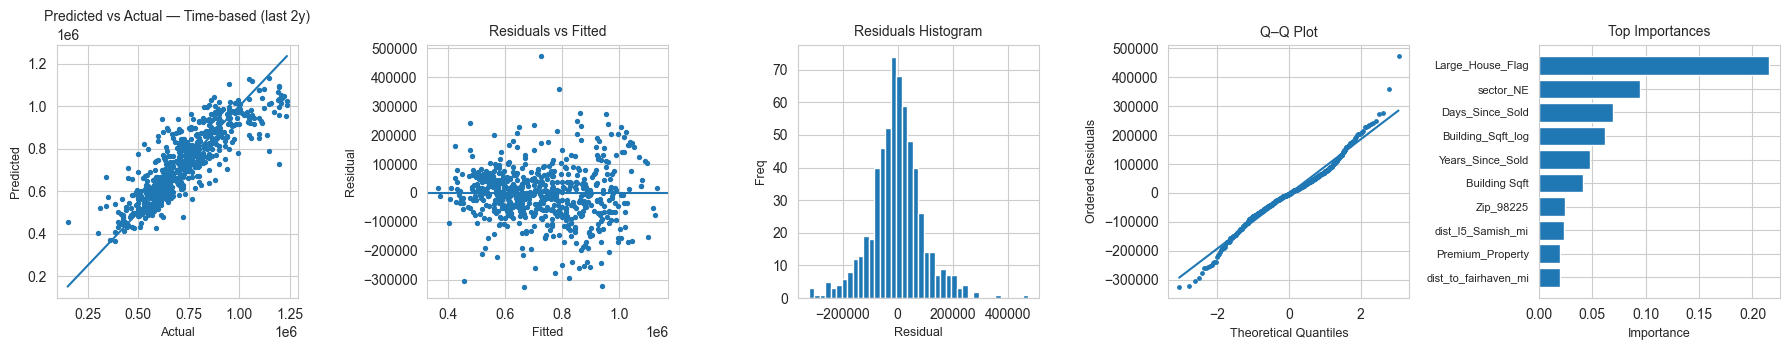

In [36]:
# Example: evaluate your tuned XGBoost on last 2 years only
drop_cols_common = ["Address", "MLS Date"]

X_train, X_test, y_train, y_test = time_based_split(
    df=df_fe,                      # or df_cleaned
    target="MLS Amount",
    date_col="MLS Date",
    drop_cols=drop_cols_common,
    test_years=1,                  # <-- last 2 years for test
    # anchor="2026-01-01",         # optional: fix an anchor if you want
)

est = xgb.XGBRegressor(
    n_estimators=2000, learning_rate=0.03, max_depth=6,
    subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
    random_state=42, n_jobs=-1, tree_method="hist", eval_metric="rmse"
)

est.fit(X_train, y_train)
y_pred = est.predict(X_test)

rmse = float(np.sqrt(mean_squared_error(y_test, y_pred)))
r2_tr = float(est.score(X_train, y_train))
r2_te = float(r2_score(y_test, y_pred))
mae, mape = mae_mape(y_test, y_pred)

print(f"Train R²: {r2_tr:.3f} | Test R²: {r2_te:.3f} | RMSE: {rmse:,.0f} | MAE: {mae:,.0f} | MAPE: {mape:.2f}%")
plot_diagnostics_row(y_test, y_pred, est, feature_names=X_train.columns.tolist(),
                     title_suffix=" — Time-based (last 2y)")

Linear (FE)
-----------
Train R²: 0.731 | Test R²: 0.758 | RMSE: 100,496 | MAE: 73,922 | MAPE: 17.18%


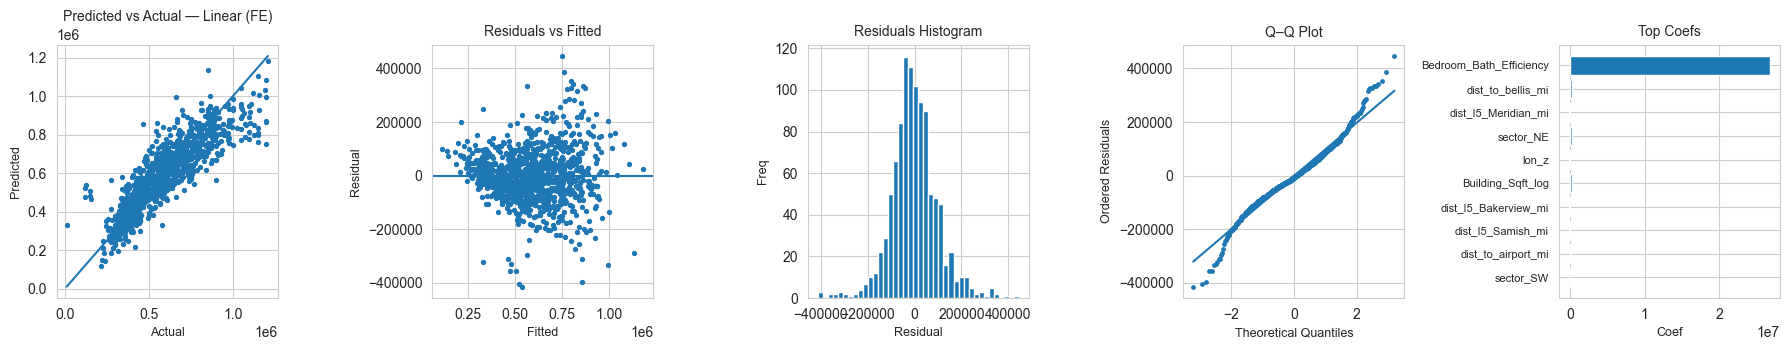

RidgeCV (FE)
------------
Train R²: 0.725 | Test R²: 0.753 | RMSE: 101,691 | MAE: 74,908 | MAPE: 17.45%


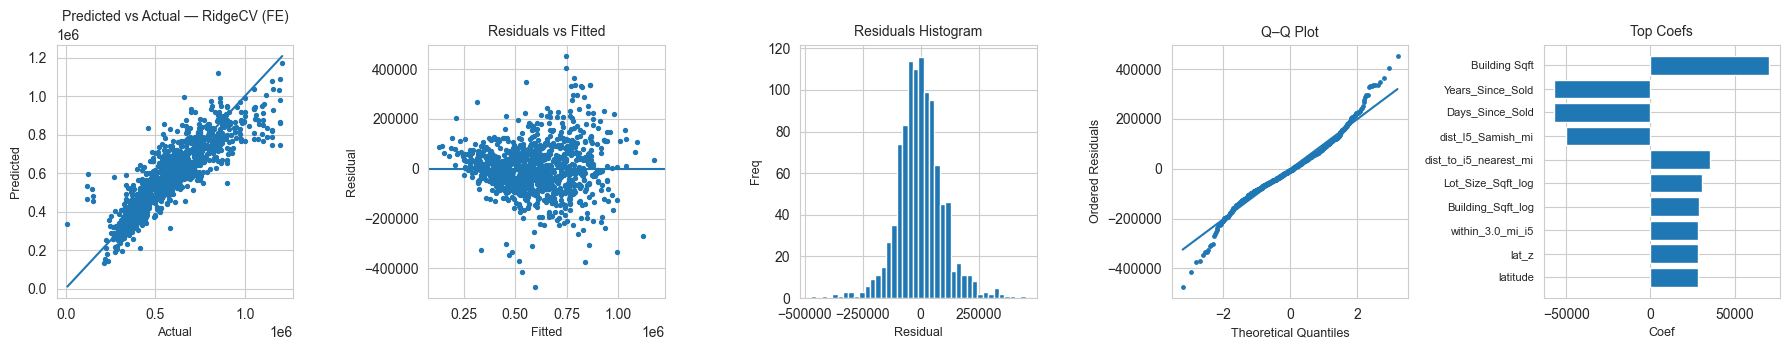

LassoCV (FE)
------------
Train R²: 0.730 | Test R²: 0.757 | RMSE: 100,820 | MAE: 74,086 | MAPE: 17.23%


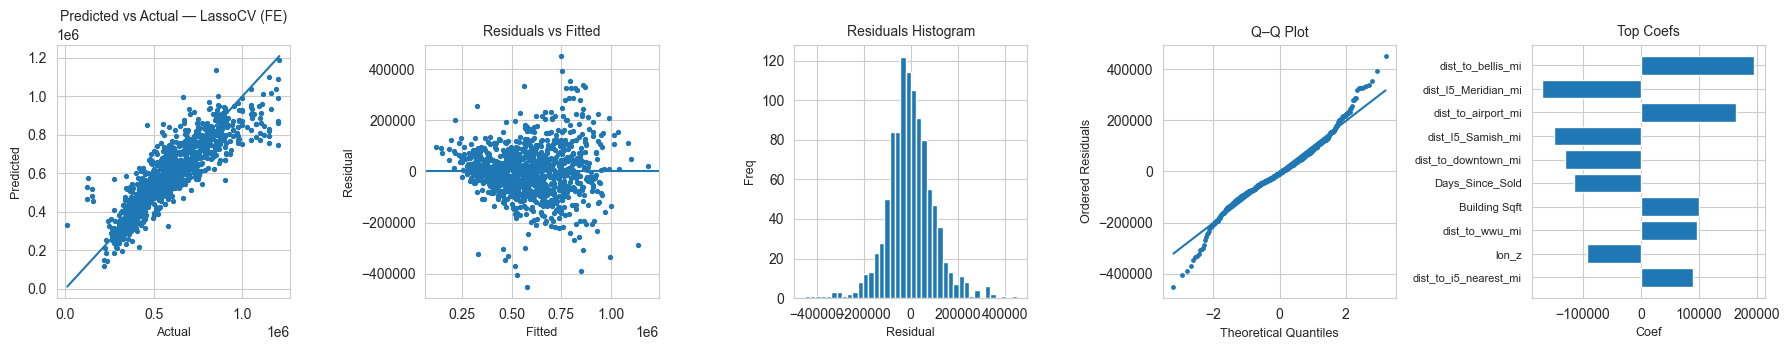

ElasticNetCV (FE)
-----------------
Train R²: 0.730 | Test R²: 0.757 | RMSE: 100,820 | MAE: 74,086 | MAPE: 17.23%


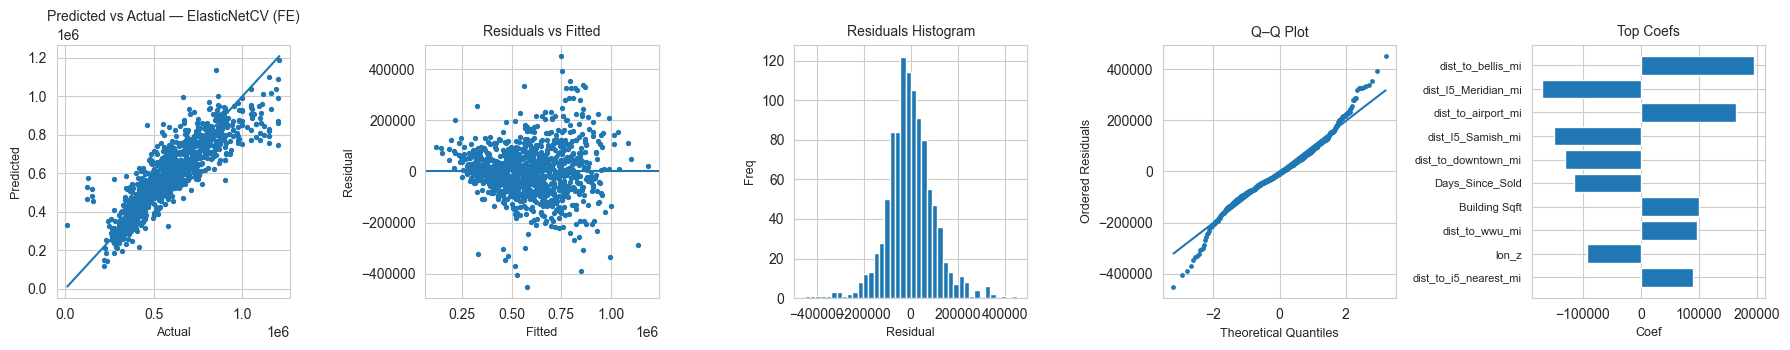

RandomForest (FE)
-----------------
Train R²: 0.943 | Test R²: 0.803 | RMSE: 90,729 | MAE: 64,305 | MAPE: 15.56%


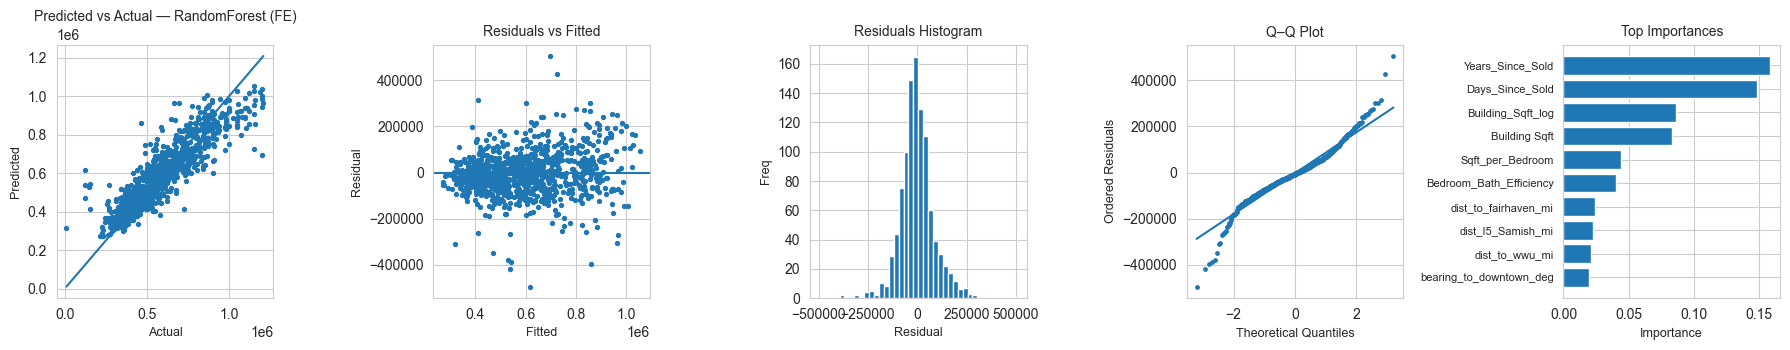

XGBoost (FE)
------------
Train R²: 0.999 | Test R²: 0.835 | RMSE: 82,952 | MAE: 58,231 | MAPE: 13.87%


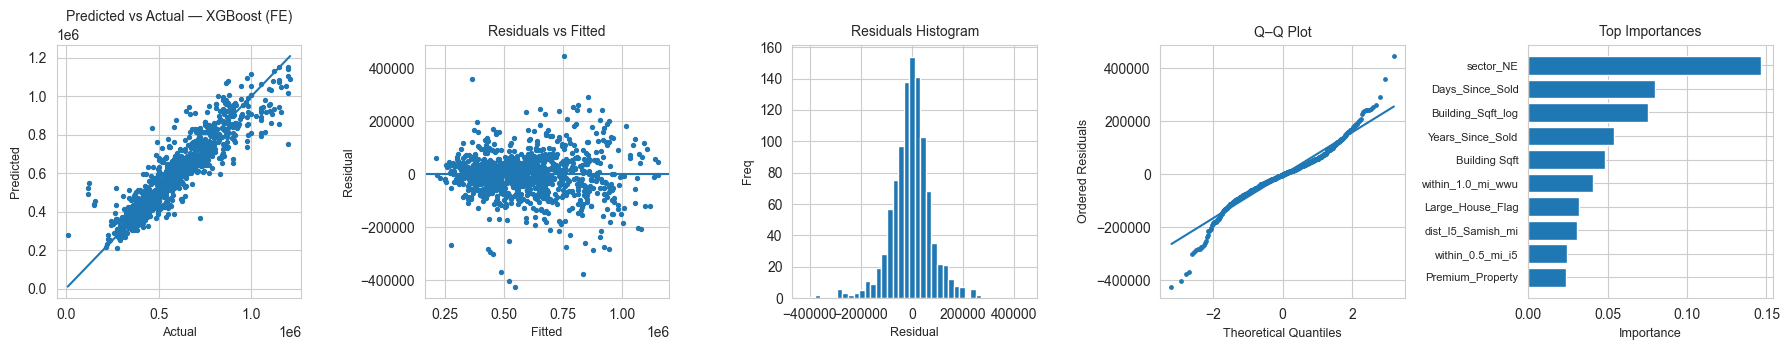

,Model,Train R²,Test R²,Test RMSE,Test MAE,Test MAPE (%)
0,Linear (FE),0.730771,0.758408,100496.442418,73921.685942,17.179719
1,RidgeCV (FE),0.724955,0.752630,101691.173795,74907.885798,17.453456
2,LassoCV (FE),0.729526,0.756849,100820.212392,74086.230453,17.232960
3,ElasticNetCV (FE),0.729526,0.756849,100820.212392,74086.230453,17.232960
4,RandomForest (FE),0.943174,0.803087,90729.118870,64304.580446,15.560807
5,XGBoost (FE),0.998745,0.835398,82951.979296,58231.064751,13.872958


In [37]:
models_fe = {
    "Linear": lambda: LinearRegression(),
    "RidgeCV": lambda: Pipeline([("scaler", StandardScaler()), ("ridge", RidgeCV(alphas=np.logspace(-3,3,21), cv=5))]),
    "LassoCV": lambda: Pipeline([("scaler", StandardScaler()), ("lasso", LassoCV(alphas=np.logspace(-3,3,21), cv=5, max_iter=2000))]),
    "ElasticNetCV": lambda: Pipeline([("scaler", StandardScaler()), ("enet", ElasticNetCV(l1_ratio=[.2,.5,.8,.9,.95,1.0], alphas=np.logspace(-3,3,21), cv=5, max_iter=2000))]),
    "RandomForest": lambda: RandomForestRegressor(
        n_estimators=500, max_depth=None, min_samples_split=4, min_samples_leaf=2,
        max_features="sqrt", n_jobs=-1, random_state=42
    ),
    "XGBoost": lambda: xgb.XGBRegressor(
        n_estimators=2000, learning_rate=0.03, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
        random_state=42, n_jobs=-1, tree_method="hist", eval_metric="rmse"
    ),
}

results_fe = run_experiments(
    df=df_fe, target="MLS Amount",
    drop_cols=drop_cols_common, model_registry=models_fe,
    label="FE"
)
results_fe